##  Step 1 Generate sim_rates

In [3]:
import pandas as pd
import numpy as np
import os

In [4]:
"""
using swap rate to construct DFT curve
"""
corr=pd.read_excel("fwd_rates_correl.xlsx", sheet_name ="change_corr").to_numpy()[1:,1:]
curve = pd.read_excel("values of swaptions_and_bermudan_v4.xlsx", sheet_name ="cms")

In [5]:
curve

,tenor,swap rate
0,0.019231,0.1511
1,0.038462,0.1630
2,0.057692,0.1609
3,0.083333,0.1582
4,0.166667,0.2029
5,0.250000,0.2519
6,0.500000,0.2776
7,0.750000,0.2568
8,1.000000,0.2411
9,1.750000,0.2297


In [6]:
from scipy import interpolate, stats, optimize
#fit cubic spline to curve to get other maturities
maturities = np.arange(1, 21)*0.5
cs = interpolate.CubicSpline(curve["tenor"], curve["swap rate"])
cms = np.array(pd.DataFrame({"maturity" : maturities,"rate" : cs(maturities)/100}))
par=cms[:,1]

# boostrap discount prices from par rate
DFT=np.zeros(cms.shape[0])
DFT[0]=1/(1+par[0]/2)
for i in range(1,20):
    DFT[i]=(1-par[i]/2 * np.sum(DFT))/(par[i]/2+1) 


#decompose historical correlation matrix
eig_vec = np.linalg.eig(corr)[1]
eig_inv = np.linalg.inv(eig_vec)

In [7]:
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation


In [9]:
def smm(initial_curve, corr, paths, factors, eig):
    """
    Args:
     initial_curve :the initial discount curve bootstrapped from cms
     corr : historical correlation matrix (19x19) (1 less than # of semi-annual discount bonds available)
     paths : number of simulated rate paths
     factors : number of factors affecting the correlation
     eig : new eigen values that generates the correlation
    """
    N = 20
    step = 21
    paths = int(paths)
    rates = np.zeros((N, step, paths))
    rates[:,0,:] = initial_curve.reshape(N, 1) #initial discount vector
    np.random.seed(345)
    
    for i in range(1,step):
        row = i-1 #matured row (as next time step shortest dated bond matures)
        rates[row,i,:] = 1 #worth par when they mature
        
        #find r
        #shortest dated rate
        r = (rates[row,i-1,:]**(-1) - 1)*2
        
        #new eigen values:
        new_eig = np.zeros((N-1,N-1))
        factors = factors #number of factors
        new_eig_val = np.concatenate((eig, np.repeat(1e-10, N-1-factors)), axis = 0) #to make sure it's positive definite
        new_eig[np.diag_indices(N-1)] = new_eig_val
        
        #create new covariance matrix
        
        cov_mat = np.dot(np.dot(eig_vec, new_eig), eig_inv)        
        #cholesky decomposition for correlated variables
        # cor_mat=correlation_from_covariance(cov_mat)
        # chol=np.linalg.cholesky(cor_mat)
        
        # #cholesky decomposition for correlated variables
        chol = np.linalg.cholesky(cov_mat) #lower triangular L
        
        #vol of forward curves
        vol = np.sqrt(np.diag(cov_mat))
#        vol=vol_test/100
        #Time-Homogeneous (TH)
        vol = vol[0:(N-i)].reshape(-1,1) #first 19, 18, 17, ...
        
        #simulate correlated brownian paths
        #w/ anti thetic variates
        z = np.random.normal(size = (int(np.ceil(paths/2)), (N-1) ))
        z = np.r_[z, -z][0:paths,:] #anti-thetic
        
        #grab relevant dwt (cut down last vectors)
        dwt = chol @ z.T #result: dwt = (N x simulated paths)
        dwt = dwt[0:(N-i),:] #first 19, 18, 17, ...
        
        #calculate forward rates from previous vector of discount rates:
        forward = 2 * ((rates[row:-1, i-1 ,:] / rates[(row+1):, i-1 ,:]) - 1)
        
        #get jacobian matrix
        di = np.diag_indices(N-i)
        jacobian = np.zeros((N-i, N-i, paths))
        #fill main diagonal
        diags = (rates[row:-1, i-1 ,:]) / -(rates[(row+1):, i-1 ,:])**2
        jacobian[di] = diags
        
        #fill offset diagonal
        di = (di[0][1:], di[1][:-1])
        diags = 1/(rates[(row + 2):, i-1 ,:]) #row+2
        jacobian[di] = diags
        
        #inverse
        inv_jacobian = np.linalg.inv(jacobian.T).T
        
        # =============================================================================
        # evolve
        # dD = rD(i-1) * (1/2) + J**-1 * F * vol * dwt * sqrt(0.5)
        # =============================================================================  
        #diffusion
        diffusion = np.einsum('ijk,jk->ik', inv_jacobian, forward*vol)
        # check 
        all(np.allclose( diffusion[:, j].reshape(-1,1) , inv_jacobian[:,:,j] @ (forward[:,j].reshape(-1,1) * vol) ) for j in range(paths) )
                                              
        rates[(row+1):,i,:] = (rates[(row+1):,i-1,:] + r * rates[(row+1):,i-1,:] * 0.5 +
                                diffusion * dwt * np.sqrt(0.5))        
    return rates

In [10]:
para=np.array([1.24445565e+00, 1.03384821e-01, 7.25724878e-02, 7.00277649e-03]) 

sim_rates=smm(DFT, corr, 5000, len(para),para)
sim_rates_10k=smm(DFT, corr, 10000, len(para),para)
sim_rates_50k=smm(DFT, corr, 50000, len(para),para)
sim_rates_100k=smm(DFT, corr, 100000, len(para),para)

In [11]:
sim_rates[:5,:5,1]

array([[0.99861392, 1.        , 0.        , 0.        , 0.        ],
       [0.99759357, 0.99896366, 1.        , 0.        , 0.        ],
       [0.99652022, 0.99785927, 0.99904042, 1.        , 0.        ],
       [0.99554908, 0.99682642, 0.99812227, 0.99897508, 1.        ],
       [0.99447329, 0.99565606, 0.99709571, 0.99783977, 0.99916139]])

#### To make sure that we  can use the same data to generate our result, I used the saved sim_rates in the following steps, which may not be the best one to calibrate the market. 

In [53]:
# load the saved data
#load_rates=np.loadtxt('sim_rates.txt')
# original sim_rates.shape=(20,20,5000)
#sim_rates=load_rates.reshape(load_rates.shape[0],load_rates.shape[1]//5000,5000) # depends on the simulation paths

###  Step 2 Price a swaption using LSM

In [54]:
def ContinuationValue(x,method,k,y):
    L=np.zeros(shape=(k,len(x)))
    b=np.zeros(k)
    if method=="Hermite":
        L[0,:]=np.ones_like(x)
        L[1,:]= 2*x
        for i in range(2,k):
            L[i,:]=2*x*L[i-1,:]-2*(i-1)*L[i-2,:]
    if method=="Laguerre":
        if k==2:
            L[0,:]=np.exp(-x/2)
            L[1,:]=np.exp(-x/2)*(1-x)
        if k==3:
            L[0,:]=np.exp(-x/2)
            L[1,:]=np.exp(-x/2)*(1-x)
            L[2,:]=np.exp(-x/2)*(1-2*x+1/2*np.power(x,2))
        if k==4:
            L[0,:]=np.exp(-x/2)
            L[1,:]=np.exp(-x/2)*(1-x)
            L[2,:]=np.exp(-x/2)*(1-2*x+1/2*np.power(x,2))
            L[3,:]=np.exp(-x/2)*(1-3*x+3/2*np.power(x,2)-1/6*np.power(x,3))
    if method=="Monomials":
        for i in range(0,k):
            L[i,:]=np.power(x,i)
    A=np.zeros(shape=(k,k))
    for i in range(0,k):
        b[i]=np.sum(y*L[i,:])
        for j in range(0,k):
            A[j,i]=np.sum(L[i,:]*L[j,:])
    a= np.dot(np.linalg.inv(A),b)
    V=np.sum(L*a[:,np.newaxis],axis=0)# sum cols
    return  V.reshape((-1,1))

In [55]:
def Laguerre_feature(x,k):
#    x=ev.ravel()
#    k=3
    L=np.zeros(shape=(k,len(x)))
    if k==2:
        L[0,:]=np.exp(-x/2)
        L[1,:]=np.exp(-x/2)*(1-x)
    if k==3:
        L[0,:]=np.exp(-x/2)
        L[1,:]=np.exp(-x/2)*(1-x)
        L[2,:]=np.exp(-x/2)*(1-2*x+1/2*np.power(x,2))
    if k==4:
        L[0,:]=np.exp(-x/2)
        L[1,:]=np.exp(-x/2)*(1-x)
        L[2,:]=np.exp(-x/2)*(1-2*x+1/2*np.power(x,2))
        L[3,:]=np.exp(-x/2)*(1-3*x+3/2*np.power(x,2)-1/6*np.power(x,3))
    return L.T

In [56]:
from sklearn.linear_model import Lasso
def lasso_regressor(x,y,alpha):
    lassoreg = Lasso(fit_intercept=False,alpha=alpha,normalize=True, max_iter=1e3)
    lassoreg.fit(x,y)
    y_pred = lassoreg.predict(x)
    return y_pred


In [57]:
def Bermudan_swaption_lsm_full(lockout,maturity,sim_rates,strike,alpha):    
    expiry=int(2*lockout)
    tenor=int(2*maturity)
    
    step=tenor-expiry  # 18
    paths=sim_rates.shape[2] # 5000
    di = np.diag_indices(expiry) # 1y 2 dis
    
# discount factor for calculate the final prc
    cmmf = np.prod(sim_rates[di], axis = 0) # (5000,1)
    
    rates=sim_rates[expiry:tenor,expiry:tenor,:] #18*18*5000
    
    di=np.diag_indices(int(tenor-expiry-1))
    di=(di[0]+expiry,di[1]+expiry)
    disc_mat=sim_rates[di]
    
# discount map for each related time step 
    discount_mat=np.hstack((np.ones((paths,1)),np.cumprod(sim_rates[di],axis=0).T)) #5000 * 18

# initial matrix
    value_mat=np.zeros((paths,step)) # value_mat 5000*18
    index_mat=np.zeros((paths,step)) # value_mat 5000*18
    payoff_mat=np.zeros_like(value_mat) # value_mat 5000*18
       
# calculate the par rate at 18 possible excercise date
    denominator=np.sum(sim_rates[expiry-1:tenor,expiry:tenor,:],axis=0)-1 # 18*5000 3D to 2D
    
    numerator=2*(1-sim_rates[int(tenor-1),expiry:tenor,:]) # 18*5000
    par=numerator/denominator # 19*5000
    payoff_mat = 0.5 * np.maximum(strike-par.T, 0) * denominator.T #5000 *100
    
    index_mat[:,-1]=np.where(payoff_mat[:,-1]>0,1,0) #5000*1
    value_mat[:,-1]=payoff_mat[:,-1] # 5000*1
# European swaption price and ex prob
    Euro_prc=np.mean(payoff_mat[:,0]*cmmf)
    ex_prob=np.sum(np.where(payoff_mat[:,0]>0,1,0))/paths    
            
    for i in range(step-2,-1,-1):
        y=value_mat[:,i+1].reshape((paths,1)) # 5000*1
        bond_prc=rates[i:int(tenor-expiry),i,:].T # 5000*n
        cv=disc_mat[i].reshape((paths,1))*y # 5000*1
        ev=payoff_mat[:,i].reshape((paths,1)) # 5000*1        
# construct the basis functions        
#        swap_value = np.repeat(ev, 3, axis = 1) ** np.arange(1, 4) # 5000*3
        swap_value = Laguerre_feature(ev.ravel(),3)
        constant=np.ones((paths,1))
#        basis=np.hstack((np.hstack((constant,bond_prc)),swap_value))
        bond_prc_laguerre=np.apply_along_axis(Laguerre_feature,0,bond_prc,k=4).reshape((paths,-1))
        basis=np.hstack((np.hstack((constant,bond_prc_laguerre)),swap_value))
#        
        # linear regression
        cv_hat=lasso_regressor(basis,cv,alpha).reshape((paths,1))
        value_mat[:,i]=np.where(ev>cv_hat,ev,cv).ravel()
        index_mat[:,i]=np.where(ev>cv_hat,1,0).ravel()
        
        for j in range(i+1,index_mat.shape[1]):
            index_mat[:,j][index_mat[:,int(i)]==1]=0
        
             
    prob=pd.DataFrame({'Time_step': np.arange(expiry,tenor),
                       'ex_prob_Euro':np.append(ex_prob,np.repeat(0,step-1)),
                       'ex_prob_LSM':np.sum(index_mat,axis=0)/paths})
             

    price_lsm=np.mean(np.sum(np.multiply(discount_mat,np.multiply(index_mat,payoff_mat)),axis=1)*cmmf)    
    return Euro_prc,price_lsm,prob

In [58]:
def Bermudan_swaption_lsm(lockout,maturity,sim_rates,strike,alpha):   
    expiry=int(2*lockout)
    tenor=int(2*maturity)
    
    step=tenor-expiry  # 18
    paths=sim_rates.shape[2] # 5000
    di = np.diag_indices(expiry) # 1y 2 dis
    
# discount factor for calculate the final prc
    cmmf = np.prod(sim_rates[di], axis = 0) # (5000,1)
    
    rates=sim_rates[expiry:tenor,expiry:tenor,:] #18*18*5000
    
    di=np.diag_indices(int(tenor-expiry-1))
    di=(di[0]+expiry,di[1]+expiry)
    disc_mat=sim_rates[di]
    
# discount map for each related time step 
    discount_mat=np.hstack((np.ones((paths,1)),np.cumprod(sim_rates[di],axis=0).T)) #5000 * 18

# initial matrix
    value_mat=np.zeros((paths,step)) # value_mat 5000*18
    index_mat=np.zeros((paths,step)) # value_mat 5000*18
    payoff_mat=np.zeros_like(value_mat) # value_mat 5000*18
       
# calculate the par rate at 18 possible excercise date
    denominator=np.sum(sim_rates[expiry-1:tenor,expiry:tenor,:],axis=0)-1 # 18*5000 3D to 2D
    
    numerator=2*(1-sim_rates[int(tenor-1),expiry:tenor,:]) # 18*5000
    par=numerator/denominator # 19*5000
    payoff_mat = 0.5 * np.maximum(strike-par.T, 0) * denominator.T #5000 *100
    
    index_mat[:,-1]=np.where(payoff_mat[:,-1]>0,1,0) #5000*1
    value_mat[:,-1]=payoff_mat[:,-1] # 5000*1
# European swaption price and ex prob
    Euro_prc=np.mean(payoff_mat[:,0]*cmmf)
    ex_prob=np.sum(np.where(payoff_mat[:,0]>0,1,0))/paths    
            
    for i in range(step-2,-1,-1):
        y=value_mat[:,i+1].reshape((paths,1)) # 5000*1
        bond_prc=rates[i:int(tenor-expiry),i,:].T # 5000*n
        cv=disc_mat[i].reshape((paths,1))*y # 5000*1
        ev=payoff_mat[:,i].reshape((paths,1)) # 5000*1
        
# construct the basis functions        
#        swap_value = np.repeat(ev, 3, axis = 1) ** np.arange(1, 4) # 5000*3
        swap_value = Laguerre_feature(ev.ravel(),3)
        constant=np.ones((paths,1))
#        basis=np.hstack((np.hstack((constant,bond_prc)),swap_value))
        bond_prc_laguerre=np.apply_along_axis(Laguerre_feature,0,bond_prc,k=4).reshape((paths,-1))
        basis=np.hstack((np.hstack((constant,bond_prc_laguerre)),swap_value))
        
#        
        # linear regression  for ITM options
        mask=ev.ravel()>0
        ev=ev[mask]
        cv=cv[mask]
        basis=basis[mask]
        
        cv_hat=lasso_regressor(basis,cv,alpha).reshape((len(cv),1))
        value_mat[mask,i]=np.where(ev>cv_hat,ev,cv).ravel()
        index_mat[mask,i]=np.where(ev>cv_hat,1,0).ravel()
        
        for j in range(i+1,index_mat.shape[1]):
            index_mat[:,j][index_mat[:,int(i)]==1]=0
        
             
    prob=pd.DataFrame({'Time_step': np.arange(expiry,tenor),
                       'ex_prob_Euro':np.append(ex_prob,np.repeat(0,step-1)),
                       'ex_prob_LSM':np.sum(index_mat,axis=0)/paths})
             

    price_lsm=np.mean(np.sum(np.multiply(discount_mat,np.multiply(index_mat,payoff_mat)),axis=1)*cmmf)    
    return Euro_prc,price_lsm,prob

In [59]:
## for test 10 nc 1    
lockout=1
maturity=10
strike=0.008
alpha=0.001


In [60]:
%%time
prc_lsm_full=Bermudan_swaption_lsm_full(lockout,maturity,sim_rates,strike,alpha)

Wall time: 248 ms


In [61]:
print('European swaption pirce: {}'.format(prc_lsm_full[0]))
print('American swaption pirce: {}'.format(prc_lsm_full[1]))

European swaption pirce: 0.006939140046653583
American swaption pirce: 0.007624504483292219


In [62]:
%%time
prc_lsm=Bermudan_swaption_lsm(lockout,maturity,sim_rates,strike,alpha)

Wall time: 237 ms


In [63]:
print('European swaption pirce: {}'.format(prc_lsm[0]))
print('American swaption pirce: {}'.format(prc_lsm[1]))

European swaption pirce: 0.006939140046653583
American swaption pirce: 0.007562926519406778


In [64]:
print('Excercise Probability Table')
prc_lsm[2]

Excercise Probability Table


,Time_step,ex_prob_Euro,ex_prob_LSM
0,2,0.708,0.4452
1,3,0.000,0.0638
2,4,0.000,0.0312
3,5,0.000,0.0138
4,6,0.000,0.0094
5,7,0.000,0.0088
6,8,0.000,0.0070
7,9,0.000,0.0060
8,10,0.000,0.0042
9,11,0.000,0.0048


##  Step 3 Train NN model

In [65]:
import torch
import torch.optim as optim
from torch.utils.data.dataset import random_split
import time

In [66]:
class PyTMinMaxScalerVectorized(object):
    """
    Transforms each channel to the range [0, 1].
    """
    def __call__(self, tensor):
        dist = (tensor.max(dim=1, keepdim=True)[0] - tensor.min(dim=1, keepdim=True)[0])
        dist[dist==0.] = 1.
        scale = 1.0 /  dist
        tensor.mul_(scale).sub_(tensor.min(dim=1, keepdim=True)[0])
        return tensor
    
scaler=PyTMinMaxScalerVectorized()

In [67]:
def trainNN(basis,cv,n_epochs,batch_size,learningrate):    
    x_train=torch.tensor(basis,dtype=torch.float)
    scaler(x_train)
    y_train=torch.tensor(cv,dtype=torch.float)
    features_num=int(basis.shape[1])
    dataset = torch.utils.data.TensorDataset(x_train, y_train.view(-1,1))
    train_len=int(basis.shape[0]*0.9)
    valid_len=basis.shape[0]-train_len
    train_dataset,valid_dataset=random_split(dataset,[train_len,valid_len])
    
    train_loader = torch.utils.data.DataLoader(dataset = train_dataset, 
                                               batch_size=batch_size, 
                                               shuffle=True)
    valid_loader=torch.utils.data.DataLoader(dataset=valid_dataset,
                                             batch_size=batch_size,
                                             shuffle=True)    
    
# define a model    
    model=torch.nn.Sequential(
            torch.nn.Linear(features_num,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,1))# n values
    
    optimizer=optim.Adam(model.parameters(),lr=learningrate)

    train_loss=[]
    valid_loss=[]
    
    for epoch in range(n_epochs):
        for i, (features, cv_value) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(features.float())
            loss = torch.nn.functional.mse_loss(output,cv_value)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())            
        
        with torch.no_grad():
            for j, (features_val, cv_val) in enumerate(valid_loader):
                model.eval()
                output_val = model(features_val.float())
                loss_val = torch.nn.functional.mse_loss(output_val,cv_val)
                valid_loss.append(loss_val.item())
                
        loss_avg=np.sqrt(np.array(train_loss).mean())
        val_loss_avg=np.sqrt(np.array(valid_loss).mean())
        
        print("Epoch {}/{}, train_loss: {:.5f}, valid_loss: {:.5f}".format(epoch+1,n_epochs, loss_avg,  val_loss_avg))
        
    y_hat =np.squeeze(model(x_train)).detach().numpy().reshape((cv.shape[0],-1))
    return y_hat

In [205]:
def Bermudan_swaption_nn(lockout,maturity,sim_rates,strike,n_epochs,batch_size,learningrate):
       
    expiry=int(2*lockout)
    tenor=int(2*maturity)
    
    step=tenor-expiry  # 18
    paths=sim_rates.shape[2] # 5000
    di = np.diag_indices(expiry) # 1y 2 dis
    
# discount factor for calculate the final prc
    cmmf = np.prod(sim_rates[di], axis = 0) # (5000,1)
    
    rates=sim_rates[expiry:tenor,expiry:tenor,:] #18*18*5000
    
    di=np.diag_indices(int(tenor-expiry-1))
    di=(di[0]+expiry,di[1]+expiry)
    disc_mat=sim_rates[di]
    
# discount map for each related time step 
    discount_mat=np.hstack((np.ones((paths,1)),np.cumprod(sim_rates[di],axis=0).T)) #5000 * 18

# initial matrix

    value_rlnn,index_rlnn=np.zeros((paths,step)),np.zeros((paths,step))
    
# calculate the par rate at 18 possible excercise date
    denominator=np.sum(sim_rates[expiry-1:tenor,expiry:tenor,:],axis=0)-1 # 18*5000 3D to 2D
    
    numerator=2*(1-sim_rates[int(tenor-1),expiry:tenor,:]) # 18*5000
    par=numerator/denominator # 19*5000
    payoff_mat = 0.5 * np.maximum(strike-par.T, 0) * denominator.T #5000 *100

    
    index_rlnn[:,-1]=np.where(payoff_mat[:,-1]>0,1,0)
    value_rlnn[:,-1]=payoff_mat[:,-1]
    
# European swaption price and ex prob
    Euro_prc=np.mean(payoff_mat[:,0]*cmmf)
    ex_prob=np.sum(np.where(payoff_mat[:,0]>0,1,0))/paths    
            
    for i in range(step-2,-1,-1):
        y=value_rlnn[:,i+1].reshape((paths,1)) # 5000*1
        bond_prc=rates[i:int(tenor-expiry),i,:].T # 5000*n
        cv=disc_mat[i].T.reshape((paths,1))*y # 5000*1
        ev=payoff_mat[:,i].reshape((paths,1)) # 5000*1 
        
# construct the basis functions        
#        swap_value = np.repeat(ev, 3, axis = 1) ** np.arange(1, 4) # 5000*3
        swap_value = Laguerre_feature(ev.ravel(),3)
        constant=np.ones((paths,1))
#        basis=np.hstack((np.hstack((constant,bond_prc)),swap_value))
        bond_prc_laguerre=np.apply_along_axis(Laguerre_feature,0,bond_prc,k=4).reshape((paths,-1))
        basis=np.hstack((np.hstack((constant,bond_prc_laguerre)),swap_value))
        

        # Regress now NN
        mask=ev.ravel()>0
        ev=ev[mask]
        cv=cv[mask] #(1327, 1)
        basis=basis[mask] # (1327, 10)
        
        
        print('At step {}'.format(i+2))
        cv_rlnn=trainNN(basis,cv,n_epochs,batch_size,learningrate)
        value_rlnn[mask,i]=np.where(ev>cv_rlnn,ev,cv).ravel() # cv instead of cv_rlnn
        index_rlnn[mask,i]=np.where(ev>cv,1,0).ravel()
        
        for j in range(i+1,index_rlnn.shape[1]):            
             index_rlnn[:,j][index_rlnn[:,int(i)]==1]=0
             
    prob=pd.DataFrame({'Time_step': np.arange(expiry,tenor),
                       'ex_prob_Euro':np.append(ex_prob,np.repeat(0,step-1)),
                       'ex_prob_RLNN':np.sum(index_rlnn,axis=0)/paths})

    price_rlnn=np.mean(np.sum(np.multiply(discount_mat,np.multiply(index_rlnn,payoff_mat)),axis=1)*cmmf)
    
    return Euro_prc,price_rlnn,prob

In [270]:
## for test 10 nc 1

lockout=1
maturity=10
strike=0.008
learningrate=0.01
n_epochs=30
batch_size=64
seed=123
learningrate=0.001
sim_rates=sim_rates


In [271]:
%%time
prc_nn=Bermudan_swaption_nn(lockout,maturity,sim_rates,strike,n_epochs,batch_size,learningrate)

At step 18
Epoch 1/30, train_loss: 0.01122, valid_loss: 0.00223
Epoch 2/30, train_loss: 0.00841, valid_loss: 0.00271
Epoch 3/30, train_loss: 0.00694, valid_loss: 0.00224
Epoch 4/30, train_loss: 0.00603, valid_loss: 0.00197
Epoch 5/30, train_loss: 0.00540, valid_loss: 0.00179
Epoch 6/30, train_loss: 0.00494, valid_loss: 0.00165
Epoch 7/30, train_loss: 0.00458, valid_loss: 0.00155
Epoch 8/30, train_loss: 0.00429, valid_loss: 0.00147
Epoch 9/30, train_loss: 0.00405, valid_loss: 0.00140
Epoch 10/30, train_loss: 0.00385, valid_loss: 0.00135
Epoch 11/30, train_loss: 0.00368, valid_loss: 0.00130
Epoch 12/30, train_loss: 0.00353, valid_loss: 0.00127
Epoch 13/30, train_loss: 0.00339, valid_loss: 0.00123
Epoch 14/30, train_loss: 0.00327, valid_loss: 0.00120
Epoch 15/30, train_loss: 0.00317, valid_loss: 0.00118
Epoch 16/30, train_loss: 0.00307, valid_loss: 0.00116
Epoch 17/30, train_loss: 0.00299, valid_loss: 0.00114
Epoch 18/30, train_loss: 0.00291, valid_loss: 0.00112
Epoch 19/30, train_loss: 0

Epoch 3/30, train_loss: 0.03455, valid_loss: 0.02068
Epoch 4/30, train_loss: 0.03000, valid_loss: 0.01803
Epoch 5/30, train_loss: 0.02689, valid_loss: 0.01621
Epoch 6/30, train_loss: 0.02459, valid_loss: 0.01488
Epoch 7/30, train_loss: 0.02281, valid_loss: 0.01385
Epoch 8/30, train_loss: 0.02138, valid_loss: 0.01302
Epoch 9/30, train_loss: 0.02019, valid_loss: 0.01234
Epoch 10/30, train_loss: 0.01920, valid_loss: 0.01177
Epoch 11/30, train_loss: 0.01834, valid_loss: 0.01128
Epoch 12/30, train_loss: 0.01759, valid_loss: 0.01085
Epoch 13/30, train_loss: 0.01694, valid_loss: 0.01049
Epoch 14/30, train_loss: 0.01635, valid_loss: 0.01016
Epoch 15/30, train_loss: 0.01583, valid_loss: 0.00986
Epoch 16/30, train_loss: 0.01535, valid_loss: 0.00959
Epoch 17/30, train_loss: 0.01492, valid_loss: 0.00936
Epoch 18/30, train_loss: 0.01453, valid_loss: 0.00913
Epoch 19/30, train_loss: 0.01417, valid_loss: 0.00894
Epoch 20/30, train_loss: 0.01383, valid_loss: 0.00876
Epoch 21/30, train_loss: 0.01353, v

Epoch 4/30, train_loss: 0.01260, valid_loss: 0.00719
Epoch 5/30, train_loss: 0.01159, valid_loss: 0.00698
Epoch 6/30, train_loss: 0.01086, valid_loss: 0.00686
Epoch 7/30, train_loss: 0.01029, valid_loss: 0.00676
Epoch 8/30, train_loss: 0.00987, valid_loss: 0.00669
Epoch 9/30, train_loss: 0.00951, valid_loss: 0.00663
Epoch 10/30, train_loss: 0.00922, valid_loss: 0.00661
Epoch 11/30, train_loss: 0.00897, valid_loss: 0.00656
Epoch 12/30, train_loss: 0.00876, valid_loss: 0.00649
Epoch 13/30, train_loss: 0.00857, valid_loss: 0.00645
Epoch 14/30, train_loss: 0.00841, valid_loss: 0.00648
Epoch 15/30, train_loss: 0.00826, valid_loss: 0.00652
Epoch 16/30, train_loss: 0.00814, valid_loss: 0.00648
Epoch 17/30, train_loss: 0.00803, valid_loss: 0.00653
Epoch 18/30, train_loss: 0.00793, valid_loss: 0.00650
Epoch 19/30, train_loss: 0.00783, valid_loss: 0.00646
Epoch 20/30, train_loss: 0.00775, valid_loss: 0.00644
Epoch 21/30, train_loss: 0.00767, valid_loss: 0.00644
Epoch 22/30, train_loss: 0.00759, 

Epoch 7/30, train_loss: 0.00884, valid_loss: 0.00758
Epoch 8/30, train_loss: 0.00871, valid_loss: 0.00756
Epoch 9/30, train_loss: 0.00860, valid_loss: 0.00754
Epoch 10/30, train_loss: 0.00852, valid_loss: 0.00752
Epoch 11/30, train_loss: 0.00845, valid_loss: 0.00749
Epoch 12/30, train_loss: 0.00839, valid_loss: 0.00758
Epoch 13/30, train_loss: 0.00834, valid_loss: 0.00759
Epoch 14/30, train_loss: 0.00831, valid_loss: 0.00757
Epoch 15/30, train_loss: 0.00828, valid_loss: 0.00754
Epoch 16/30, train_loss: 0.00823, valid_loss: 0.00752
Epoch 17/30, train_loss: 0.00818, valid_loss: 0.00754
Epoch 18/30, train_loss: 0.00813, valid_loss: 0.00754
Epoch 19/30, train_loss: 0.00810, valid_loss: 0.00751
Epoch 20/30, train_loss: 0.00806, valid_loss: 0.00748
Epoch 21/30, train_loss: 0.00803, valid_loss: 0.00745
Epoch 22/30, train_loss: 0.00799, valid_loss: 0.00742
Epoch 23/30, train_loss: 0.00796, valid_loss: 0.00738
Epoch 24/30, train_loss: 0.00793, valid_loss: 0.00735
Epoch 25/30, train_loss: 0.0078

In [272]:
print('European swaption pirce: {}'.format(prc_nn[0]))

European swaption pirce: 0.006939140046653583


In [273]:
print('Bermudan swaption pirce: {}'.format(prc_nn[1]))

Bermudan swaption pirce: 0.008788116431004304


In [274]:
print('Excercise Probability Table')
prc_nn[2]

Excercise Probability Table


,Time_step,ex_prob_Euro,ex_prob_RLNN
0,2,0.708,0.4824
1,3,0.000,0.1858
2,4,0.000,0.0670
3,5,0.000,0.0296
4,6,0.000,0.0128
5,7,0.000,0.0080
6,8,0.000,0.0086
7,9,0.000,0.0032
8,10,0.000,0.0028
9,11,0.000,0.0034


In [74]:
import xgboost
import pycaret
from pycaret.regression import *

#### The following cells is used to show how our XGBoost model is tuned at each time step

In [37]:
# create test data
x=np.random.normal(size=(1000,20)) # 1000 obervations with 20 features
y=np.random.normal(size=1000)

df=pd.DataFrame(x)
df['y']=y
df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,y
0,0.891232,0.089891,-0.228538,-0.778409,-1.076887,-0.153667,0.329244,0.058707,0.061015,-1.920108,...,0.003232,-1.028953,0.224267,2.352286,1.218678,0.123032,-0.255382,-1.606264,-1.321751,-0.386526
1,0.186863,0.275995,2.344247,0.407977,-0.298008,-0.671003,-0.804555,-0.702106,-0.121839,0.242805,...,-0.747894,0.908411,0.764664,-0.329349,-0.580607,-1.154345,0.302104,-0.995525,-0.555875,-0.140838
2,-1.833466,-0.039210,0.611904,0.431463,0.538390,1.925852,0.420892,-0.637434,-0.289325,-2.530420,...,1.013046,-0.010963,-0.884846,1.516457,-0.852977,1.103977,-0.260355,1.323633,0.198478,0.884186
3,-1.832918,1.104425,-1.412599,2.472525,-0.188355,-0.011710,-1.058770,-0.205268,-0.050947,-0.681839,...,0.094868,3.024385,-0.873285,0.123418,0.235007,-2.619171,-1.170854,0.984160,0.488254,2.639618
4,-1.682840,-1.151599,1.043588,1.185431,0.456189,-0.580031,-0.203965,-2.090221,1.259256,0.975432,...,1.158101,0.092897,-0.345609,0.295462,0.023780,0.276973,0.899548,1.958868,0.814505,-0.435555


In [38]:
# set up environment
"""
 target: target predict value
 html: Notebook is True
 normalize_method: z_score, minmax....
 train_size: default 0.7, chosen as train and valid data, left as test data, here we choose 0.9
"""


exp_reg=setup(df,target='y',html=True,
                  normalize=True,
                  normalize_method='minmax',
                  data_split_shuffle=True,
                  train_size=0.9) 

,Description,Value
0,session_id,4754
1,Target,y
2,Original Data,"(1000, 21)"
3,Missing Values,False
4,Numeric Features,20
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(900, 20)"


In [39]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,0.7814,0.9383,0.9675,-0.0058,0.5768,1.159,0.008
en,Elastic Net,0.7814,0.9383,0.9675,-0.0058,0.5768,1.159,0.007
llar,Lasso Least Angle Regression,0.7814,0.9383,0.9675,-0.0058,0.5768,1.159,0.012
br,Bayesian Ridge,0.7823,0.9409,0.9689,-0.0089,0.578,1.16,0.008
omp,Orthogonal Matching Pursuit,0.7846,0.9451,0.9711,-0.0136,0.5457,1.561,0.009
ridge,Ridge Regression,0.7866,0.9558,0.9767,-0.0258,0.526,1.385,0.008
lr,Linear Regression,0.7875,0.9581,0.9778,-0.0284,0.5224,1.413,0.009
lar,Least Angle Regression,0.7875,0.9581,0.9778,-0.0284,0.5224,1.413,0.008
huber,Huber Regressor,0.7907,0.9614,0.9795,-0.0318,0.5146,1.546,0.009
et,Extra Trees Regressor,0.7949,0.9629,0.9802,-0.0334,0.5016,1.739,0.211


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=4754,
      selection='cyclic', tol=0.0001, warm_start=False)

In [40]:
# return the best model
compare_models(sort='R2')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,0.7814,0.9383,0.9675,-0.0058,0.5768,1.159,0.007
en,Elastic Net,0.7814,0.9383,0.9675,-0.0058,0.5768,1.159,0.007
llar,Lasso Least Angle Regression,0.7814,0.9383,0.9675,-0.0058,0.5768,1.159,0.007
br,Bayesian Ridge,0.7823,0.9409,0.9689,-0.0089,0.578,1.16,0.007
omp,Orthogonal Matching Pursuit,0.7846,0.9451,0.9711,-0.0136,0.5457,1.561,0.008
ridge,Ridge Regression,0.7866,0.9558,0.9767,-0.0258,0.526,1.385,0.007
lr,Linear Regression,0.7875,0.9581,0.9778,-0.0284,0.5224,1.413,0.009
lar,Least Angle Regression,0.7875,0.9581,0.9778,-0.0284,0.5224,1.413,0.007
huber,Huber Regressor,0.7907,0.9614,0.9795,-0.0318,0.5146,1.546,0.01
et,Extra Trees Regressor,0.7949,0.9629,0.9802,-0.0334,0.5016,1.739,0.205


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=4754,
      selection='cyclic', tol=0.0001, warm_start=False)

In [41]:
"""
fold: k_fold validation
round: round digits
estimtor: 'xgboost'
"""
xgb=create_model('xgboost',fold=10,cross_validation=True,round=6)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.82705,1.10395,1.05069,-0.144272,0.448954,16.4483
1,0.792315,0.975749,0.9878,-0.11047,0.426496,1.61091
2,0.914441,1.22117,1.10506,-0.262818,0.424968,6.10835
3,0.893664,1.17067,1.08198,-0.293927,0.431852,3.02101
4,0.924988,1.2632,1.12392,-0.327255,0.412864,1.79451
5,0.872792,1.13729,1.06644,-0.36733,0.428397,2.36737
6,0.931947,1.3772,1.17354,-0.322317,0.42308,2.4195
7,0.903684,1.29788,1.13925,-0.194493,0.452334,1.55859
8,0.849634,1.01758,1.00875,-0.331904,0.433642,2.55809
9,0.844918,1.11098,1.05403,-0.184232,0.462144,1.7366


In [42]:
"""
estimator: a algorithm or a defined model by create_model()
optimize: cretirion
n_iter: default 500
choose_better: at least return the basic model
"""
tuned_xgb=tune_model(xgb,optimize='R2',n_iter=100,choose_better=True,round=6)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.789519,0.948559,0.97394,0.016797,0.562861,3.26843
1,0.7642,0.880946,0.938587,-0.002577,0.536489,1.02483
2,0.788939,0.991195,0.995588,-0.025003,0.524114,2.04016
3,0.774376,0.895563,0.946342,0.010146,0.531062,1.35682
4,0.816377,0.951831,0.975618,-0.0001,0.533972,1.08008
5,0.76278,0.875844,0.935865,-0.052997,0.505015,1.73213
6,0.822949,1.06041,1.02976,-0.018145,0.568202,1.12923
7,0.841527,1.06797,1.03343,0.017102,0.561674,1.10662
8,0.719216,0.783862,0.88536,-0.025988,0.49384,1.52328
9,0.754257,0.920123,0.959231,0.019213,0.532063,1.40583


In [43]:
# we can custom our parameters for tuning
"""
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
}
"""
params = {
    'colsample_bytree':[0.4,0.6,0.8],
    'gamma':[0,0.03,0.1,0.3],
    'min_child_weight':[1.5,6,10],
    'learning_rate':[0.1,0.07,0.01],
    'max_depth':[3,5],
    'n_estimators':[10],
    'reg_alpha':[1e-5, 1e-2,  0.75],
    'reg_lambda':[1e-5, 1e-2, 0.45],
    'subsample':[0.6,0.95]}

In [44]:
tuned_xgb_2=tune_model(xgb,optimize='R2',custom_grid=params,choose_better=True,round=6)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.786034,0.992191,0.996088,-0.028429,0.500336,1.72736
1,0.81609,0.99509,0.997542,-0.132482,0.484065,1.24804
2,0.791174,0.986167,0.99306,-0.019803,0.521374,3.14754
3,0.807007,0.960835,0.980222,-0.061997,0.498004,2.17847
4,0.806409,0.95253,0.975976,-0.000834,0.497357,1.07564
5,0.749972,0.872635,0.93415,-0.04914,0.475243,2.38227
6,0.85546,1.11518,1.05602,-0.070735,0.523907,1.45188
7,0.857415,1.09145,1.04473,-0.004507,0.540506,1.47522
8,0.730689,0.837337,0.915061,-0.09598,0.456599,1.19495
9,0.81217,0.971476,0.985635,-0.035526,0.491884,1.75773


#### Well, seems the default n_iter tuning works better than our custom discrete training!

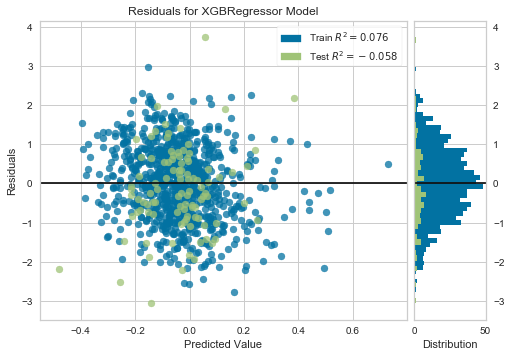

In [46]:
# plot the model 
plot_model(tuned_xgb)

In [47]:
model=finalize_model(tuned_xgb)

(array([ 17., 123., 393., 338.,  78.,  33.,  10.,   6.,   1.,   1.]),
 array([-0.35881704, -0.24916968, -0.13952231, -0.02987495,  0.07977241,
         0.18941978,  0.29906714,  0.4087145 ,  0.51836187,  0.62800923,
         0.73765659]),
 <a list of 10 Patch objects>)

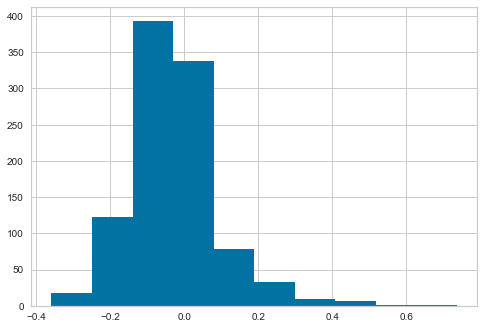

In [48]:
# predict out of sample and plot the distribution
import matplotlib.pyplot as plt
df2=pd.DataFrame(np.random.normal(size=(500,20)))
y_hat=predict_model(model,data=df)['Label'].values
plt.hist(y_hat)

###  Now we are going to use the same process for our XGBoost 


In [84]:
def train_xgb_basic(basis,cv,seed,step):
    step=np.int(step)
    df=pd.DataFrame(basis)
    df['cv']=cv.ravel().astype('float64')    
    exp_reg=setup(df,target='cv',html=False,
                  normalize=True,
                  normalize_method='minmax',
                  data_split_shuffle=True,
                  train_size=0.9, # should it be 1 or less than 1
                  session_id=seed)    
    xgb=create_model('xgboost',fold=10,cross_validation=True,round=6)
    tuned_xgb=tune_model(xgb,optimize='R2',n_iter=200,choose_better=True,round=6)
    # to see the parameters
    print(tuned_xgb)
    # finalize the model to predict
    model=finalize_model(tuned_xgb)
    y_hat=predict_model(model,data=df.iloc[:,:-1])['Label'].values.reshape((-1,1))
    
    # save the model for each time step
    save_model(tuned_xgb,'step'+str(step)+'tuned_xgb')
    
    return y_hat
    

In [99]:
def train_xgb_fixed(basis,cv,seed):
    train_x=basis
    train_y=cv
# base model  from the step 18 parameters
    xgb_model = xgboost.XGBRegressor(seed=seed,base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.212, max_delta_step=0, max_depth=3,
             min_child_weight=3, monotone_constraints='()',
             n_estimators=70, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=123, reg_alpha=0.01,
             reg_lambda=5, scale_pos_weight=4.800000000000001, subsample=0.5,
             tree_method='auto', validate_parameters=1, verbosity=0)

# fit the model
    xgb_model.fit(train_x,train_y)
    y_xgb=xgb_model.predict(train_x).reshape((-1,1))
    return y_xgb

In [86]:
def Bermudan_swaption_xgboost(lockout,maturity,sim_rates,strike,seed):
   
    expiry=int(2*lockout)
    tenor=int(2*maturity)
    
    step=tenor-expiry  # 18
    paths=sim_rates.shape[2] # 5000
    di = np.diag_indices(expiry) # 1y 2 dis
    
# discount factor for calculate the final prc
    cmmf = np.prod(sim_rates[di], axis = 0) # (5000,1)
    
    rates=sim_rates[expiry:tenor,expiry:tenor,:] #18*18*5000
    
    di=np.diag_indices(int(tenor-expiry-1))
    di=(di[0]+expiry,di[1]+expiry)
    disc_mat=sim_rates[di]
    
# discount map for each related time step 
    discount_mat=np.hstack((np.ones((paths,1)),np.cumprod(sim_rates[di],axis=0).T)) #5000 * 18

# initial matrix

    value_xgb,index_xgb=np.zeros((paths,step)),np.zeros((paths,step))
    
# calculate the par rate at 18 possible excercise date
    denominator=np.sum(sim_rates[expiry-1:tenor,expiry:tenor,:],axis=0)-1 # 18*5000 3D to 2D
    
    numerator=2*(1-sim_rates[int(tenor-1),expiry:tenor,:]) # 18*5000
    par=numerator/denominator # 19*5000
    payoff_mat = 0.5 * np.maximum(strike-par.T, 0) * denominator.T #5000 *100

    
    index_xgb[:,-1]=np.where(payoff_mat[:,-1]>0,1,0)
    value_xgb[:,-1]=payoff_mat[:,-1]
    
# European swaption price and ex prob
    Euro_prc=np.mean(payoff_mat[:,0]*cmmf)
    ex_prob=np.sum(np.where(payoff_mat[:,0]>0,1,0))/paths    
            
    for i in range(step-2,-1,-1):
        y=value_xgb[:,i+1].reshape((paths,1)) # 5000*1
        bond_prc=rates[i:int(tenor-expiry),i,:].T # 5000*n
        cv=disc_mat[i].T.reshape((paths,1))*y # 5000*1
        ev=payoff_mat[:,i].reshape((paths,1)) # 5000*1 
        
# construct the basis functions        
#        swap_value = np.repeat(ev, 3, axis = 1) ** np.arange(1, 4) # 5000*3
        swap_value = Laguerre_feature(ev.ravel(),3)
        constant=np.ones((paths,1))
#        basis=np.hstack((np.hstack((constant,bond_prc)),swap_value))
        bond_prc_laguerre=np.apply_along_axis(Laguerre_feature,0,bond_prc,k=3).reshape((paths,-1))
        basis=np.hstack((np.hstack((constant,bond_prc_laguerre)),swap_value))
        

        # Regress now NN
        mask=ev.ravel()>0
        ev=ev[mask]
        cv=cv[mask]
        basis=basis[mask]
        
        cv_xgb=train_xgb_basic(basis,cv,seed,i+1)
        value_xgb[mask,i]=np.where(ev>cv_xgb,ev,cv).ravel()
        index_xgb[mask,i]=np.where(ev>cv_xgb,1,0).ravel()
        
        for j in range(i+1,index_xgb.shape[1]):            
             index_xgb[:,j][index_xgb[:,int(i)]==1]=0
             
    prob=pd.DataFrame({'Time_step': np.arange(expiry,tenor),
                       'ex_prob_Euro':np.append(ex_prob,np.repeat(0,step-1)),
                       'ex_prob_xgb':np.sum(index_xgb,axis=0)/paths})

    price_xgb=np.mean(np.sum(np.multiply(discount_mat,np.multiply(index_xgb,payoff_mat)),axis=1)*cmmf)
    
    return Euro_prc,price_xgb,prob

In [222]:
def Bermudan_swaption_xgboost_fixed(lockout,maturity,sim_rates,strike,seed):
   
    expiry=int(2*lockout)
    tenor=int(2*maturity)
    
    step=tenor-expiry  # 18
    paths=sim_rates.shape[2] # 5000
    di = np.diag_indices(expiry) # 1y 2 dis
    
# discount factor for calculate the final prc
    cmmf = np.prod(sim_rates[di], axis = 0) # (5000,1)
    
    rates=sim_rates[expiry:tenor,expiry:tenor,:] #18*18*5000
    
    di=np.diag_indices(int(tenor-expiry-1))
    di=(di[0]+expiry,di[1]+expiry)
    disc_mat=sim_rates[di]
    
# discount map for each related time step 
    discount_mat=np.hstack((np.ones((paths,1)),np.cumprod(sim_rates[di],axis=0).T)) #5000 * 18

# initial matrix

    value_xgb,index_xgb=np.zeros((paths,step)),np.zeros((paths,step))
    
# calculate the par rate at 18 possible excercise date
    denominator=np.sum(sim_rates[expiry-1:tenor,expiry:tenor,:],axis=0)-1 # 18*5000 3D to 2D
    
    numerator=2*(1-sim_rates[int(tenor-1),expiry:tenor,:]) # 18*5000
    par=numerator/denominator # 19*5000
    payoff_mat = 0.5 * np.maximum(strike-par.T, 0) * denominator.T #5000 *100

    
    index_xgb[:,-1]=np.where(payoff_mat[:,-1]>0,1,0)
    value_xgb[:,-1]=payoff_mat[:,-1]
    
# European swaption price and ex prob
    Euro_prc=np.mean(payoff_mat[:,0]*cmmf)
    ex_prob=np.sum(np.where(payoff_mat[:,0]>0,1,0))/paths    
            
    for i in range(step-2,-1,-1):
        y=value_xgb[:,i+1].reshape((paths,1)) # 5000*1
        bond_prc=rates[i:int(tenor-expiry),i,:].T # 5000*n
        cv=disc_mat[i].T.reshape((paths,1))*y # 5000*1
        ev=payoff_mat[:,i].reshape((paths,1)) # 5000*1 
        
# construct the basis functions        
#        swap_value = np.repeat(ev, 3, axis = 1) ** np.arange(1, 4) # 5000*3
        swap_value = Laguerre_feature(ev.ravel(),3)
        constant=np.ones((paths,1))
#        basis=np.hstack((np.hstack((constant,bond_prc)),swap_value))
        bond_prc_laguerre=np.apply_along_axis(Laguerre_feature,0,bond_prc,k=4).reshape((paths,-1))
        basis=np.hstack((np.hstack((constant,bond_prc_laguerre)),swap_value))
        

        # Regress now NN
        mask=ev.ravel()>0
        ev=ev[mask]
        cv=cv[mask]
        basis=basis[mask]
        
        cv_xgb=train_xgb_fixed(basis,cv,seed)
        value_xgb[mask,i]=np.where(ev>cv_xgb,ev,cv).ravel()
        index_xgb[mask,i]=np.where(ev>cv_xgb,1,0).ravel()
        
        for j in range(i+1,index_xgb.shape[1]):            
             index_xgb[:,j][index_xgb[:,int(i)]==1]=0
             
    prob=pd.DataFrame({'Time_step': np.arange(expiry,tenor),
                       'ex_prob_Euro':np.append(ex_prob,np.repeat(0,step-1)),
                       'ex_prob_xgb':np.sum(index_xgb,axis=0)/paths})

    price_xgb=np.mean(np.sum(np.multiply(discount_mat,np.multiply(index_xgb,payoff_mat)),axis=1)*cmmf)
    
    return Euro_prc,price_xgb,prob

In [87]:
## for test 10 nc 1
lockout=1
maturity=10
strike=0.008
seed=123

In [88]:
%%time
prc_xgb=Bermudan_swaption_xgboost(lockout,maturity,sim_rates,strike,seed)

Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
0,Numeric
1,Numeric
2,Numeric
3,Numeric
4,Numeric
5,Numeric
6,Numeric
7,Numeric
8,Numeric
9,Numeric



Setup Succesfully Completed!
                               Description             Value
0                               session_id               123
1                                   Target                cv
2                            Original Data        (1197, 11)
3                           Missing Values             False
4                         Numeric Features                10
5                     Categorical Features                 0
6                         Ordinal Features             False
7                High Cardinality Features             False
8                  High Cardinality Method              None
9                    Transformed Train Set         (1077, 2)
10                    Transformed Test Set          (120, 2)
11                      Shuffle Train-Test              True
12                     Stratify Train-Test             False
13                          Fold Generator             KFold
14                             Fold Number             

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   33.2s finished


           MAE  MSE      RMSE        R2     RMSLE      MAPE
0     0.000396  0.0  0.000494  0.615762  0.000493  1.263288
1     0.000379  0.0  0.000470  0.555483  0.000470  0.667941
2     0.000377  0.0  0.000462  0.556673  0.000462  0.583528
3     0.000446  0.0  0.000529  0.528817  0.000528  1.608209
4     0.000409  0.0  0.000499  0.560220  0.000498  0.842193
5     0.000395  0.0  0.000493  0.590900  0.000493  0.706455
6     0.000384  0.0  0.000478  0.610268  0.000477  0.570300
7     0.000441  0.0  0.000549  0.335140  0.000548  0.835100
8     0.000400  0.0  0.000468  0.655033  0.000468  0.664132
9     0.000359  0.0  0.000456  0.616401  0.000456  0.827740
Mean  0.000399  0.0  0.000490  0.562470  0.000489  0.856889
SD    0.000026  0.0  0.000028  0.083850  0.000028  0.313613
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             l

Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
0,Numeric
1,Numeric
2,Numeric
3,Numeric
4,Numeric
5,Numeric
6,Numeric
7,Numeric
8,Numeric
9,Numeric



Setup Succesfully Completed!
                               Description             Value
0                               session_id               123
1                                   Target                cv
2                            Original Data        (1156, 14)
3                           Missing Values             False
4                         Numeric Features                13
5                     Categorical Features                 0
6                         Ordinal Features             False
7                High Cardinality Features             False
8                  High Cardinality Method              None
9                    Transformed Train Set         (1040, 4)
10                    Transformed Test Set          (116, 4)
11                      Shuffle Train-Test              True
12                     Stratify Train-Test             False
13                          Fold Generator             KFold
14                             Fold Number             

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 1194 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 1544 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   43.2s finished


           MAE  MSE      RMSE        R2     RMSLE      MAPE
0     0.000523  0.0  0.000653  0.778667  0.000651  0.911061
1     0.000519  0.0  0.000643  0.799531  0.000642  0.414782
2     0.000505  0.0  0.000618  0.820842  0.000617  0.369662
3     0.000531  0.0  0.000665  0.791083  0.000664  0.562855
4     0.000503  0.0  0.000619  0.789320  0.000618  0.417280
5     0.000527  0.0  0.000670  0.804261  0.000669  0.357208
6     0.000491  0.0  0.000613  0.805052  0.000612  0.972270
7     0.000493  0.0  0.000628  0.835967  0.000627  0.335912
8     0.000498  0.0  0.000667  0.749924  0.000666  0.717349
9     0.000557  0.0  0.000692  0.788795  0.000690  0.297619
Mean  0.000515  0.0  0.000647  0.796344  0.000646  0.535600
SD    0.000020  0.0  0.000025  0.022181  0.000025  0.234498
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
            

Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
0,Numeric
1,Numeric
2,Numeric
3,Numeric
4,Numeric
5,Numeric
6,Numeric
7,Numeric
8,Numeric
9,Numeric



Setup Succesfully Completed!
                               Description             Value
0                               session_id               123
1                                   Target                cv
2                            Original Data        (1141, 17)
3                           Missing Values             False
4                         Numeric Features                16
5                     Categorical Features                 0
6                         Ordinal Features             False
7                High Cardinality Features             False
8                  High Cardinality Method              None
9                    Transformed Train Set         (1026, 4)
10                    Transformed Test Set          (115, 4)
11                      Shuffle Train-Test              True
12                     Stratify Train-Test             False
13                          Fold Generator             KFold
14                             Fold Number             

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 570 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 1152 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   53.9s finished


           MAE       MSE      RMSE        R2     RMSLE      MAPE
0     0.000772  0.000001  0.000999  0.743536  0.000997  0.466995
1     0.000737  0.000001  0.000939  0.755831  0.000937  0.571392
2     0.000837  0.000001  0.001020  0.656886  0.001018  0.316730
3     0.000719  0.000001  0.000921  0.809333  0.000918  0.406632
4     0.000791  0.000001  0.001004  0.777938  0.001001  0.502759
5     0.000716  0.000001  0.000938  0.764135  0.000936  0.285291
6     0.000767  0.000001  0.000968  0.790273  0.000965  0.301099
7     0.000749  0.000001  0.000982  0.761058  0.000979  0.335949
8     0.000764  0.000001  0.000966  0.809536  0.000963  0.762193
9     0.000772  0.000001  0.000979  0.794168  0.000976  0.429483
Mean  0.000762  0.000001  0.000972  0.766269  0.000969  0.437852
SD    0.000034  0.000000  0.000030  0.042237  0.000030  0.140060
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
            

Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
0,Numeric
1,Numeric
2,Numeric
3,Numeric
4,Numeric
5,Numeric
6,Numeric
7,Numeric
8,Numeric
9,Numeric



Setup Succesfully Completed!
                               Description             Value
0                               session_id               123
1                                   Target                cv
2                            Original Data        (1121, 20)
3                           Missing Values             False
4                         Numeric Features                19
5                     Categorical Features                 0
6                         Ordinal Features             False
7                High Cardinality Features             False
8                  High Cardinality Method              None
9                    Transformed Train Set         (1008, 4)
10                    Transformed Test Set          (113, 4)
11                      Shuffle Train-Test              True
12                     Stratify Train-Test             False
13                          Fold Generator             KFold
14                             Fold Number             

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 546 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 1346 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 1896 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  1.1min finished


           MAE       MSE      RMSE        R2     RMSLE      MAPE
0     0.001020  0.000002  0.001254  0.729682  0.001250  0.343496
1     0.000938  0.000001  0.001137  0.804308  0.001132  0.280219
2     0.000943  0.000001  0.001142  0.826201  0.001138  0.277742
3     0.001122  0.000002  0.001462  0.728189  0.001456  0.340664
4     0.001090  0.000002  0.001434  0.707326  0.001429  0.350108
5     0.001102  0.000002  0.001410  0.711407  0.001405  0.417118
6     0.001101  0.000002  0.001366  0.715890  0.001361  0.379108
7     0.001038  0.000002  0.001320  0.773546  0.001316  0.285667
8     0.001161  0.000002  0.001454  0.721027  0.001449  0.592666
9     0.001016  0.000001  0.001210  0.773463  0.001206  0.382702
Mean  0.001053  0.000002  0.001319  0.749104  0.001314  0.364949
SD    0.000071  0.000000  0.000120  0.040068  0.000119  0.087996
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
            

Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
0,Numeric
1,Numeric
2,Numeric
3,Numeric
4,Numeric
5,Numeric
6,Numeric
7,Numeric
8,Numeric
9,Numeric



Setup Succesfully Completed!
                               Description             Value
0                               session_id               123
1                                   Target                cv
2                            Original Data        (1158, 23)
3                           Missing Values             False
4                         Numeric Features                22
5                     Categorical Features                 0
6                         Ordinal Features             False
7                High Cardinality Features             False
8                  High Cardinality Method              None
9                    Transformed Train Set         (1042, 4)
10                    Transformed Test Set          (116, 4)
11                      Shuffle Train-Test              True
12                     Stratify Train-Test             False
13                          Fold Generator             KFold
14                             Fold Number             

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 546 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 1346 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 1896 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  1.2min finished


           MAE       MSE      RMSE        R2     RMSLE      MAPE
0     0.001285  0.000002  0.001569  0.774562  0.001563  0.280908
1     0.001330  0.000003  0.001623  0.738334  0.001617  0.329537
2     0.001240  0.000003  0.001609  0.740862  0.001602  0.313344
3     0.001459  0.000003  0.001810  0.686807  0.001802  0.339601
4     0.001185  0.000002  0.001450  0.778602  0.001444  0.393652
5     0.001422  0.000003  0.001799  0.770938  0.001791  0.413311
6     0.001211  0.000002  0.001510  0.744131  0.001504  0.302925
7     0.001275  0.000003  0.001591  0.775922  0.001585  0.348254
8     0.001299  0.000003  0.001613  0.725800  0.001608  0.353559
9     0.001400  0.000003  0.001792  0.662730  0.001785  0.425088
Mean  0.001311  0.000003  0.001637  0.739869  0.001630  0.350018
SD    0.000087  0.000000  0.000118  0.037356  0.000117  0.045197
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
            

Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
0,Numeric
1,Numeric
2,Numeric
3,Numeric
4,Numeric
5,Numeric
6,Numeric
7,Numeric
8,Numeric
9,Numeric



Setup Succesfully Completed!
                               Description             Value
0                               session_id               123
1                                   Target                cv
2                            Original Data        (1142, 26)
3                           Missing Values             False
4                         Numeric Features                25
5                     Categorical Features                 0
6                         Ordinal Features             False
7                High Cardinality Features             False
8                  High Cardinality Method              None
9                    Transformed Train Set         (1027, 6)
10                    Transformed Test Set          (115, 6)
11                      Shuffle Train-Test              True
12                     Stratify Train-Test             False
13                          Fold Generator             KFold
14                             Fold Number             

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 546 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 1346 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 1896 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  1.3min finished


           MAE       MSE      RMSE        R2     RMSLE      MAPE
0     0.001621  0.000004  0.001969  0.744765  0.001960  0.285738
1     0.001706  0.000004  0.002098  0.676721  0.002089  0.378556
2     0.001525  0.000004  0.001883  0.690363  0.001876  0.319070
3     0.001620  0.000004  0.002009  0.702584  0.002001  0.391905
4     0.001427  0.000003  0.001808  0.737567  0.001799  0.315837
5     0.001723  0.000005  0.002134  0.733923  0.002124  0.321172
6     0.002019  0.000006  0.002427  0.606150  0.002414  0.450565
7     0.001660  0.000004  0.002041  0.652256  0.002031  0.384841
8     0.001889  0.000006  0.002366  0.659457  0.002353  0.476981
9     0.001788  0.000005  0.002234  0.587502  0.002222  0.401194
Mean  0.001698  0.000004  0.002097  0.679129  0.002087  0.372586
SD    0.000163  0.000001  0.000189  0.051223  0.000188  0.058845
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
            

Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
0,Numeric
1,Numeric
2,Numeric
3,Numeric
4,Numeric
5,Numeric
6,Numeric
7,Numeric
8,Numeric
9,Numeric



Setup Succesfully Completed!
                               Description             Value
0                               session_id               123
1                                   Target                cv
2                            Original Data        (1185, 29)
3                           Missing Values             False
4                         Numeric Features                28
5                     Categorical Features                 0
6                         Ordinal Features             False
7                High Cardinality Features             False
8                  High Cardinality Method              None
9                    Transformed Train Set         (1066, 6)
10                    Transformed Test Set          (119, 6)
11                      Shuffle Train-Test              True
12                     Stratify Train-Test             False
13                          Fold Generator             KFold
14                             Fold Number             

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 546 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 1346 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done 1896 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  1.6min finished


           MAE       MSE      RMSE        R2     RMSLE      MAPE
0     0.001911  0.000006  0.002345  0.665556  0.002335  0.336692
1     0.001995  0.000006  0.002413  0.655502  0.002401  0.413987
2     0.001806  0.000005  0.002339  0.673242  0.002318  0.289077
3     0.002429  0.000008  0.002807  0.602760  0.002792  0.459701
4     0.002111  0.000007  0.002641  0.641411  0.002608  0.356518
5     0.001887  0.000006  0.002388  0.661480  0.002376  0.415286
6     0.002003  0.000006  0.002505  0.663189  0.002492  0.459099
7     0.001810  0.000005  0.002295  0.676367  0.002283  0.337097
8     0.001712  0.000005  0.002185  0.709240  0.002175  0.340320
9     0.002212  0.000007  0.002703  0.634321  0.002686  0.477764
Mean  0.001987  0.000006  0.002462  0.658307  0.002447  0.388554
SD    0.000204  0.000001  0.000188  0.026803  0.000185  0.061599
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             i

Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
0,Numeric
1,Numeric
2,Numeric
3,Numeric
4,Numeric
5,Numeric
6,Numeric
7,Numeric
8,Numeric
9,Numeric



Setup Succesfully Completed!
                               Description             Value
0                               session_id               123
1                                   Target                cv
2                            Original Data        (1214, 32)
3                           Missing Values             False
4                         Numeric Features                31
5                     Categorical Features                 0
6                         Ordinal Features             False
7                High Cardinality Features             False
8                  High Cardinality Method              None
9                    Transformed Train Set         (1092, 6)
10                    Transformed Test Set          (122, 6)
11                      Shuffle Train-Test              True
12                     Stratify Train-Test             False
13                          Fold Generator             KFold
14                             Fold Number             

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 482 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 832 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done 1832 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  1.6min finished


           MAE       MSE      RMSE        R2     RMSLE      MAPE
0     0.002214  0.000008  0.002789  0.688750  0.002773  0.436843
1     0.002370  0.000008  0.002822  0.695610  0.002804  0.477340
2     0.002076  0.000006  0.002483  0.665056  0.002470  0.320648
3     0.002002  0.000006  0.002425  0.703753  0.002411  0.330824
4     0.002152  0.000007  0.002687  0.664494  0.002668  0.316703
5     0.002205  0.000007  0.002652  0.606493  0.002636  0.402880
6     0.002097  0.000007  0.002573  0.622799  0.002561  0.273787
7     0.001929  0.000006  0.002412  0.751197  0.002399  0.307723
8     0.001910  0.000006  0.002467  0.778630  0.002453  0.444215
9     0.002132  0.000007  0.002620  0.639686  0.002607  0.320389
Mean  0.002109  0.000007  0.002593  0.681647  0.002578  0.363135
SD    0.000133  0.000001  0.000139  0.051399  0.000137  0.066720
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
            

Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
0,Numeric
1,Numeric
2,Numeric
3,Numeric
4,Numeric
5,Numeric
6,Numeric
7,Numeric
8,Numeric
9,Numeric



Setup Succesfully Completed!
                               Description             Value
0                               session_id               123
1                                   Target                cv
2                            Original Data        (1271, 35)
3                           Missing Values             False
4                         Numeric Features                34
5                     Categorical Features                 0
6                         Ordinal Features             False
7                High Cardinality Features             False
8                  High Cardinality Method              None
9                    Transformed Train Set        (1143, 10)
10                    Transformed Test Set         (128, 10)
11                      Shuffle Train-Test              True
12                     Stratify Train-Test             False
13                          Fold Generator             KFold
14                             Fold Number             

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 490 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 840 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 1290 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1840 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  1.9min finished


           MAE       MSE      RMSE        R2     RMSLE      MAPE
0     0.002502  0.000009  0.003069  0.599042  0.003048  0.408508
1     0.002287  0.000008  0.002820  0.701656  0.002801  0.338615
2     0.002298  0.000008  0.002851  0.682326  0.002832  0.374259
3     0.002413  0.000008  0.002913  0.665679  0.002895  0.462752
4     0.002242  0.000008  0.002844  0.708596  0.002827  0.366061
5     0.002489  0.000009  0.003021  0.662079  0.003001  0.459298
6     0.002294  0.000008  0.002812  0.590789  0.002794  0.358960
7     0.002496  0.000009  0.003048  0.656424  0.003030  0.388648
8     0.002042  0.000007  0.002550  0.780893  0.002532  0.339020
9     0.002102  0.000007  0.002566  0.760869  0.002550  0.331217
Mean  0.002316  0.000008  0.002849  0.680835  0.002831  0.382734
SD    0.000153  0.000001  0.000171  0.057965  0.000170  0.045156
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
            

Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
0,Numeric
1,Numeric
2,Numeric
3,Numeric
4,Numeric
5,Numeric
6,Numeric
7,Numeric
8,Numeric
9,Numeric



Setup Succesfully Completed!
                               Description             Value
0                               session_id               123
1                                   Target                cv
2                            Original Data        (1362, 38)
3                           Missing Values             False
4                         Numeric Features                37
5                     Categorical Features                 0
6                         Ordinal Features             False
7                High Cardinality Features             False
8                  High Cardinality Method              None
9                    Transformed Train Set         (1225, 8)
10                    Transformed Test Set          (137, 8)
11                      Shuffle Train-Test              True
12                     Stratify Train-Test             False
13                          Fold Generator             KFold
14                             Fold Number             

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 490 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 840 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 1290 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1840 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  1.8min finished


           MAE       MSE      RMSE        R2     RMSLE      MAPE
0     0.002631  0.000010  0.003203  0.626023  0.003183  0.449051
1     0.002461  0.000009  0.002969  0.773553  0.002947  0.351099
2     0.002675  0.000011  0.003343  0.635484  0.003320  0.351224
3     0.002592  0.000011  0.003313  0.628493  0.003287  0.360107
4     0.002414  0.000009  0.003012  0.621127  0.002989  0.409222
5     0.002284  0.000008  0.002871  0.722435  0.002851  0.284173
6     0.002385  0.000009  0.003009  0.688607  0.002987  0.303931
7     0.002812  0.000011  0.003354  0.687978  0.003330  0.553861
8     0.002535  0.000010  0.003084  0.706010  0.003061  0.435835
9     0.002582  0.000009  0.003068  0.643954  0.003049  0.412934
Mean  0.002537  0.000010  0.003123  0.673367  0.003100  0.391144
SD    0.000147  0.000001  0.000162  0.048208  0.000161  0.074725
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             i

Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
0,Numeric
1,Numeric
2,Numeric
3,Numeric
4,Numeric
5,Numeric
6,Numeric
7,Numeric
8,Numeric
9,Numeric



Setup Succesfully Completed!
                               Description             Value
0                               session_id               123
1                                   Target                cv
2                            Original Data        (1477, 41)
3                           Missing Values             False
4                         Numeric Features                40
5                     Categorical Features                 0
6                         Ordinal Features             False
7                High Cardinality Features             False
8                  High Cardinality Method              None
9                    Transformed Train Set         (1329, 9)
10                    Transformed Test Set          (148, 9)
11                      Shuffle Train-Test              True
12                     Stratify Train-Test             False
13                          Fold Generator             KFold
14                             Fold Number             

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 482 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 832 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1832 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  2.1min finished


           MAE       MSE      RMSE        R2     RMSLE      MAPE
0     0.002888  0.000012  0.003516  0.594225  0.003492  0.402772
1     0.002734  0.000012  0.003412  0.640300  0.003389  0.380054
2     0.002982  0.000013  0.003652  0.633338  0.003623  0.425905
3     0.002730  0.000011  0.003346  0.671283  0.003324  0.389752
4     0.002658  0.000010  0.003236  0.714978  0.003212  0.336470
5     0.002776  0.000012  0.003405  0.709465  0.003379  0.318321
6     0.002818  0.000012  0.003430  0.606017  0.003406  0.586369
7     0.002838  0.000013  0.003605  0.683559  0.003579  0.348245
8     0.002583  0.000010  0.003132  0.724888  0.003109  0.360136
9     0.002902  0.000012  0.003534  0.614454  0.003506  0.516968
Mean  0.002791  0.000012  0.003427  0.659251  0.003402  0.406499
SD    0.000114  0.000001  0.000153  0.045574  0.000151  0.080093
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             i

Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
0,Numeric
1,Numeric
2,Numeric
3,Numeric
4,Numeric
5,Numeric
6,Numeric
7,Numeric
8,Numeric
9,Numeric



Setup Succesfully Completed!
                               Description             Value
0                               session_id               123
1                                   Target                cv
2                            Original Data        (1660, 44)
3                           Missing Values             False
4                         Numeric Features                43
5                     Categorical Features                 0
6                         Ordinal Features             False
7                High Cardinality Features             False
8                  High Cardinality Method              None
9                    Transformed Train Set         (1494, 5)
10                    Transformed Test Set          (166, 5)
11                      Shuffle Train-Test              True
12                     Stratify Train-Test             False
13                          Fold Generator             KFold
14                             Fold Number             

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 546 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done 1346 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1896 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  2.2min finished


           MAE       MSE      RMSE        R2     RMSLE      MAPE
0     0.003358  0.000017  0.004099  0.542096  0.004068  0.405832
1     0.003594  0.000019  0.004404  0.509090  0.004369  0.559041
2     0.003331  0.000016  0.003963  0.595904  0.003936  0.394435
3     0.003594  0.000019  0.004322  0.573287  0.004285  0.407541
4     0.003449  0.000017  0.004163  0.609029  0.004125  0.423711
5     0.003229  0.000016  0.003939  0.609646  0.003910  0.418274
6     0.003474  0.000019  0.004361  0.528694  0.004326  0.461213
7     0.003421  0.000017  0.004142  0.519924  0.004112  0.500079
8     0.003047  0.000015  0.003902  0.570671  0.003874  0.348861
9     0.003211  0.000016  0.004040  0.583279  0.004004  0.330802
Mean  0.003371  0.000017  0.004133  0.564162  0.004101  0.424979
SD    0.000165  0.000001  0.000171  0.035093  0.000168  0.064218
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             i

Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
0,Numeric
1,Numeric
2,Numeric
3,Numeric
4,Numeric
5,Numeric
6,Numeric
7,Numeric
8,Numeric
9,Numeric



Setup Succesfully Completed!
                               Description             Value
0                               session_id               123
1                                   Target                cv
2                            Original Data        (1833, 47)
3                           Missing Values             False
4                         Numeric Features                46
5                     Categorical Features                 0
6                         Ordinal Features             False
7                High Cardinality Features             False
8                  High Cardinality Method              None
9                    Transformed Train Set         (1649, 6)
10                    Transformed Test Set          (184, 6)
11                      Shuffle Train-Test              True
12                     Stratify Train-Test             False
13                          Fold Generator             KFold
14                             Fold Number             

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 474 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done 1274 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1824 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  2.4min finished


           MAE       MSE      RMSE        R2     RMSLE      MAPE
0     0.003531  0.000019  0.004334  0.531557  0.004298  0.417738
1     0.003677  0.000020  0.004457  0.563434  0.004417  0.391415
2     0.003759  0.000019  0.004387  0.588087  0.004351  0.412965
3     0.003796  0.000022  0.004692  0.492780  0.004651  0.409971
4     0.003182  0.000015  0.003850  0.621960  0.003824  0.367929
5     0.003549  0.000019  0.004382  0.620320  0.004343  0.333315
6     0.003524  0.000019  0.004411  0.522672  0.004370  0.470551
7     0.003581  0.000018  0.004294  0.636150  0.004256  0.346051
8     0.003456  0.000018  0.004292  0.514905  0.004258  0.388522
9     0.003906  0.000022  0.004706  0.586479  0.004664  0.457142
Mean  0.003596  0.000019  0.004381  0.567835  0.004343  0.399560
SD    0.000193  0.000002  0.000226  0.047874  0.000221  0.041730
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
            

Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
0,Numeric
1,Numeric
2,Numeric
3,Numeric
4,Numeric
5,Numeric
6,Numeric
7,Numeric
8,Numeric
9,Numeric



Setup Succesfully Completed!
                               Description             Value
0                               session_id               123
1                                   Target                cv
2                            Original Data        (2135, 50)
3                           Missing Values             False
4                         Numeric Features                49
5                     Categorical Features                 0
6                         Ordinal Features             False
7                High Cardinality Features             False
8                  High Cardinality Method              None
9                    Transformed Train Set         (1921, 9)
10                    Transformed Test Set          (214, 9)
11                      Shuffle Train-Test              True
12                     Stratify Train-Test             False
13                          Fold Generator             KFold
14                             Fold Number             

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 482 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 832 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1832 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  3.0min finished


           MAE       MSE      RMSE        R2     RMSLE      MAPE
0     0.003886  0.000023  0.004755  0.565279  0.004712  0.400906
1     0.003606  0.000019  0.004398  0.603586  0.004360  0.359253
2     0.003973  0.000024  0.004892  0.543188  0.004847  0.381307
3     0.003491  0.000018  0.004271  0.638007  0.004234  0.342616
4     0.003667  0.000020  0.004491  0.596764  0.004452  0.336659
5     0.003893  0.000022  0.004656  0.569163  0.004612  0.438578
6     0.003730  0.000021  0.004556  0.584106  0.004517  0.389821
7     0.003902  0.000021  0.004594  0.555057  0.004558  0.448085
8     0.003770  0.000021  0.004530  0.550668  0.004492  0.385968
9     0.003852  0.000022  0.004718  0.554975  0.004679  0.355682
Mean  0.003777  0.000021  0.004586  0.576079  0.004546  0.383887
SD    0.000145  0.000002  0.000171  0.028042  0.000169  0.035755
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             i

Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
0,Numeric
1,Numeric
2,Numeric
3,Numeric
4,Numeric
5,Numeric
6,Numeric
7,Numeric
8,Numeric
9,Numeric



Setup Succesfully Completed!
                               Description             Value
0                               session_id               123
1                                   Target                cv
2                            Original Data        (2531, 53)
3                           Missing Values             False
4                         Numeric Features                52
5                     Categorical Features                 0
6                         Ordinal Features             False
7                High Cardinality Features             False
8                  High Cardinality Method              None
9                    Transformed Train Set        (2277, 11)
10                    Transformed Test Set         (254, 11)
11                      Shuffle Train-Test              True
12                     Stratify Train-Test             False
13                          Fold Generator             KFold
14                             Fold Number             

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 466 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1266 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1816 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  3.7min finished


           MAE       MSE      RMSE        R2     RMSLE      MAPE
0     0.003830  0.000022  0.004706  0.586359  0.004663  0.376820
1     0.004089  0.000025  0.004971  0.504490  0.004927  0.411395
2     0.004363  0.000029  0.005410  0.486009  0.005359  0.402909
3     0.003774  0.000021  0.004602  0.535705  0.004563  0.426907
4     0.003672  0.000020  0.004499  0.581290  0.004460  0.395153
5     0.004356  0.000031  0.005602  0.441395  0.005545  0.362402
6     0.004075  0.000024  0.004935  0.545738  0.004890  0.400750
7     0.004064  0.000024  0.004870  0.506748  0.004829  0.761211
8     0.003991  0.000024  0.004921  0.527314  0.004873  0.365757
9     0.004147  0.000026  0.005053  0.522037  0.005005  0.404344
Mean  0.004036  0.000025  0.004957  0.523708  0.004911  0.430765
SD    0.000217  0.000003  0.000322  0.040914  0.000317  0.111820
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
            

Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
0,Numeric
1,Numeric
2,Numeric
3,Numeric
4,Numeric
5,Numeric
6,Numeric
7,Numeric
8,Numeric
9,Numeric



Setup Succesfully Completed!
                               Description             Value
0                               session_id               123
1                                   Target                cv
2                            Original Data        (2949, 56)
3                           Missing Values             False
4                         Numeric Features                55
5                     Categorical Features                 0
6                         Ordinal Features             False
7                High Cardinality Features             False
8                  High Cardinality Method              None
9                    Transformed Train Set         (2654, 8)
10                    Transformed Test Set          (295, 8)
11                      Shuffle Train-Test              True
12                     Stratify Train-Test             False
13                          Fold Generator             KFold
14                             Fold Number             

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 466 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1266 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1816 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  4.2min finished


           MAE       MSE      RMSE        R2     RMSLE      MAPE
0     0.004553  0.000029  0.005425  0.551779  0.005370  0.394740
1     0.004672  0.000032  0.005655  0.401328  0.005599  0.441285
2     0.004597  0.000031  0.005591  0.389995  0.005539  0.434428
3     0.004470  0.000029  0.005356  0.498622  0.005300  0.434388
4     0.004661  0.000032  0.005623  0.422676  0.005568  0.458175
5     0.004399  0.000029  0.005358  0.393254  0.005308  0.416704
6     0.004226  0.000027  0.005210  0.505454  0.005158  0.421218
7     0.004519  0.000028  0.005336  0.430838  0.005290  0.440070
8     0.004644  0.000033  0.005703  0.383398  0.005651  0.406757
9     0.004462  0.000029  0.005393  0.487023  0.005341  0.418225
Mean  0.004520  0.000030  0.005465  0.446437  0.005412  0.426599
SD    0.000131  0.000002  0.000157  0.056375  0.000156  0.017669
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
            

Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
0,Numeric
1,Numeric
2,Numeric
3,Numeric
4,Numeric
5,Numeric
6,Numeric
7,Numeric
8,Numeric
9,Numeric



Setup Succesfully Completed!
                               Description             Value
0                               session_id               123
1                                   Target                cv
2                            Original Data        (3540, 59)
3                           Missing Values             False
4                         Numeric Features                58
5                     Categorical Features                 0
6                         Ordinal Features             False
7                High Cardinality Features             False
8                  High Cardinality Method              None
9                    Transformed Train Set         (3186, 6)
10                    Transformed Test Set          (354, 6)
11                      Shuffle Train-Test              True
12                     Stratify Train-Test             False
13                          Fold Generator             KFold
14                             Fold Number             

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 466 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1266 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1816 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  4.3min finished


           MAE       MSE      RMSE        R2     RMSLE      MAPE
0     0.005001  0.000036  0.006025  0.359437  0.005964  0.407159
1     0.004934  0.000038  0.006128  0.368003  0.006067  0.395627
2     0.004779  0.000035  0.005937  0.349902  0.005877  0.406062
3     0.004809  0.000036  0.005976  0.328930  0.005918  0.482281
4     0.005355  0.000042  0.006510  0.296054  0.006442  0.450607
5     0.004934  0.000036  0.005989  0.377571  0.005930  0.410808
6     0.004489  0.000030  0.005472  0.409454  0.005420  0.413787
7     0.004629  0.000031  0.005602  0.446595  0.005547  0.420985
8     0.004965  0.000036  0.006039  0.351366  0.005979  0.429973
9     0.004795  0.000035  0.005927  0.378850  0.005869  0.445525
Mean  0.004869  0.000036  0.005960  0.366616  0.005901  0.426281
SD    0.000221  0.000003  0.000267  0.039327  0.000263  0.024999
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
            

In [89]:
print('European swaption pirce: {}'.format(prc_xgb[0]))

European swaption pirce: 0.006939140046653583


In [90]:
print('Bermudan swaption pirce: {}'.format(prc_xgb[1]))

Bermudan swaption pirce: 0.007626313294723181


In [91]:
print('Excercise Probability Table')
prc_xgb[2]

Excercise Probability Table


,Time_step,ex_prob_Euro,ex_prob_xgb
0,2,0.708,0.4952
1,3,0.000,0.0854
2,4,0.000,0.0386
3,5,0.000,0.0150
4,6,0.000,0.0104
5,7,0.000,0.0070
6,8,0.000,0.0084
7,9,0.000,0.0086
8,10,0.000,0.0058
9,11,0.000,0.0040


In [101]:
%%time
prc_xgb_fixed=Bermudan_swaption_xgboost_fixed(lockout,maturity,sim_rates,strike,seed)

Wall time: 1.19 s


In [102]:
print('Bermudan swaption pirce: {}'.format(prc_xgb_fixed[1]))
print('Excercise Probability Table')
prc_xgb_fixed[2]

Bermudan swaption pirce: 0.007768905718105953
Excercise Probability Table


,Time_step,ex_prob_Euro,ex_prob_xgb
0,2,0.708,0.5708
1,3,0.000,0.0844
2,4,0.000,0.0308
3,5,0.000,0.0142
4,6,0.000,0.0090
5,7,0.000,0.0048
6,8,0.000,0.0052
7,9,0.000,0.0054
8,10,0.000,0.0048
9,11,0.000,0.0024


#### Last time, our initial price from XGBoost is around 0.0090, much higher than this time, but closer to the estimated values from 50K and 100K simulation. Since it's so time consuming to tune the model at each time step, and the value is pretty close to the price attained from fixed parameter model, we will use the fixed model in the following step. As we did last week, we will simulate more paths to see the difference between each model. Then we will compare 'regress now' and 'regress later'

In [275]:
output_5000=pd.DataFrame({'Algorithm':['LSM','NN','XGBoost_tuned','XGBoost_fixed'],
                          ' European price': [prc_lsm[0],prc_nn[0],prc_xgb[0],prc_xgb_fixed[0]],
                          ' Bermudan price': [prc_lsm[1],prc_nn[1],0.007626313294723181,prc_xgb_fixed[1]],
                          ' Time':['271 ms','39.4 s','38min23s ','1.2 s' ]})
output_5000

,Algorithm,European price,Bermudan price,Time
0,LSM,0.006939,0.007563,271 ms
1,NN,0.006939,0.008788,39.4 s
2,XGBoost_tuned,0.006939,0.007626,38min23s
3,XGBoost_fixed,0.006939,0.007769,1.2 s


In [105]:
# define some output functions
def print_result(prc):
    print('European swaption pirce: {}'.format(prc[0]))
    print('Bermudan swaption pirce: {}'.format(prc[1]))
    print('Excercise Probability Table')
    print(prc[2])
    
def make_table(prc_lsm,prc_nn,prc_xgb):
    output=pd.DataFrame({'Algorithm':['LSM','NN','XGBoost'],
                          ' European price': [prc_lsm[0],prc_nn[0],prc_xgb[0]],
                          ' Bermudan price': [prc_lsm[1],prc_nn[1],prc_xgb[1]]})
    return output


In [106]:
%%time
prc_lsm_10k=Bermudan_swaption_lsm(lockout,maturity,sim_rates_10k,strike,alpha)

Wall time: 439 ms


In [107]:
print_result(prc_lsm_10k)

European swaption pirce: 0.006946037983725924
Bermudan swaption pirce: 0.007548136794892565
Excercise Probability Table
    Time_step  ex_prob_Euro  ex_prob_LSM
0           2        0.7087       0.4488
1           3        0.0000       0.0644
2           4        0.0000       0.0287
3           5        0.0000       0.0161
4           6        0.0000       0.0111
5           7        0.0000       0.0084
6           8        0.0000       0.0048
7           9        0.0000       0.0044
8          10        0.0000       0.0042
9          11        0.0000       0.0036
10         12        0.0000       0.0045
11         13        0.0000       0.0059
12         14        0.0000       0.0051
13         15        0.0000       0.0055
14         16        0.0000       0.0050
15         17        0.0000       0.0086
16         18        0.0000       0.0162
17         19        0.0000       0.0120


In [276]:
%%time
prc_nn_10k=Bermudan_swaption_nn(lockout,maturity,sim_rates_10k,strike,n_epochs,batch_size,learningrate)

At step 18
Epoch 1/30, train_loss: 0.00959, valid_loss: 0.00142
Epoch 2/30, train_loss: 0.00686, valid_loss: 0.00123
Epoch 3/30, train_loss: 0.00562, valid_loss: 0.00109
Epoch 4/30, train_loss: 0.00488, valid_loss: 0.00102
Epoch 5/30, train_loss: 0.00438, valid_loss: 0.00097
Epoch 6/30, train_loss: 0.00401, valid_loss: 0.00094
Epoch 7/30, train_loss: 0.00373, valid_loss: 0.00094
Epoch 8/30, train_loss: 0.00350, valid_loss: 0.00092
Epoch 9/30, train_loss: 0.00331, valid_loss: 0.00090
Epoch 10/30, train_loss: 0.00315, valid_loss: 0.00089
Epoch 11/30, train_loss: 0.00301, valid_loss: 0.00088
Epoch 12/30, train_loss: 0.00289, valid_loss: 0.00089
Epoch 13/30, train_loss: 0.00278, valid_loss: 0.00088
Epoch 14/30, train_loss: 0.00269, valid_loss: 0.00088
Epoch 15/30, train_loss: 0.00261, valid_loss: 0.00087
Epoch 16/30, train_loss: 0.00253, valid_loss: 0.00086
Epoch 17/30, train_loss: 0.00246, valid_loss: 0.00085
Epoch 18/30, train_loss: 0.00240, valid_loss: 0.00087
Epoch 19/30, train_loss: 0

Epoch 5/30, train_loss: 0.00885, valid_loss: 0.00460
Epoch 6/30, train_loss: 0.00830, valid_loss: 0.00466
Epoch 7/30, train_loss: 0.00790, valid_loss: 0.00467
Epoch 8/30, train_loss: 0.00755, valid_loss: 0.00464
Epoch 9/30, train_loss: 0.00726, valid_loss: 0.00463
Epoch 10/30, train_loss: 0.00702, valid_loss: 0.00459
Epoch 11/30, train_loss: 0.00683, valid_loss: 0.00457
Epoch 12/30, train_loss: 0.00665, valid_loss: 0.00453
Epoch 13/30, train_loss: 0.00649, valid_loss: 0.00451
Epoch 14/30, train_loss: 0.00635, valid_loss: 0.00449
Epoch 15/30, train_loss: 0.00624, valid_loss: 0.00451
Epoch 16/30, train_loss: 0.00615, valid_loss: 0.00467
Epoch 17/30, train_loss: 0.00608, valid_loss: 0.00469
Epoch 18/30, train_loss: 0.00601, valid_loss: 0.00466
Epoch 19/30, train_loss: 0.00593, valid_loss: 0.00465
Epoch 20/30, train_loss: 0.00585, valid_loss: 0.00472
Epoch 21/30, train_loss: 0.00578, valid_loss: 0.00469
Epoch 22/30, train_loss: 0.00572, valid_loss: 0.00468
Epoch 23/30, train_loss: 0.00566,

Epoch 8/30, train_loss: 0.00882, valid_loss: 0.00674
Epoch 9/30, train_loss: 0.00855, valid_loss: 0.00667
Epoch 10/30, train_loss: 0.00831, valid_loss: 0.00664
Epoch 11/30, train_loss: 0.00812, valid_loss: 0.00658
Epoch 12/30, train_loss: 0.00796, valid_loss: 0.00661
Epoch 13/30, train_loss: 0.00784, valid_loss: 0.00656
Epoch 14/30, train_loss: 0.00770, valid_loss: 0.00652
Epoch 15/30, train_loss: 0.00758, valid_loss: 0.00647
Epoch 16/30, train_loss: 0.00747, valid_loss: 0.00646
Epoch 17/30, train_loss: 0.00738, valid_loss: 0.00642
Epoch 18/30, train_loss: 0.00730, valid_loss: 0.00640
Epoch 19/30, train_loss: 0.00722, valid_loss: 0.00639
Epoch 20/30, train_loss: 0.00714, valid_loss: 0.00635
Epoch 21/30, train_loss: 0.00707, valid_loss: 0.00633
Epoch 22/30, train_loss: 0.00699, valid_loss: 0.00631
Epoch 23/30, train_loss: 0.00694, valid_loss: 0.00628
Epoch 24/30, train_loss: 0.00688, valid_loss: 0.00624
Epoch 25/30, train_loss: 0.00682, valid_loss: 0.00620
Epoch 26/30, train_loss: 0.006

Epoch 10/30, train_loss: 0.00852, valid_loss: 0.00799
Epoch 11/30, train_loss: 0.00839, valid_loss: 0.00788
Epoch 12/30, train_loss: 0.00827, valid_loss: 0.00778
Epoch 13/30, train_loss: 0.00816, valid_loss: 0.00774
Epoch 14/30, train_loss: 0.00807, valid_loss: 0.00775
Epoch 15/30, train_loss: 0.00797, valid_loss: 0.00766
Epoch 16/30, train_loss: 0.00789, valid_loss: 0.00759
Epoch 17/30, train_loss: 0.00779, valid_loss: 0.00751
Epoch 18/30, train_loss: 0.00775, valid_loss: 0.00798
Epoch 19/30, train_loss: 0.00768, valid_loss: 0.00793
Epoch 20/30, train_loss: 0.00759, valid_loss: 0.00786
Epoch 21/30, train_loss: 0.00751, valid_loss: 0.00779
Epoch 22/30, train_loss: 0.00744, valid_loss: 0.00775
Epoch 23/30, train_loss: 0.00738, valid_loss: 0.00765
Epoch 24/30, train_loss: 0.00731, valid_loss: 0.00758
Epoch 25/30, train_loss: 0.00726, valid_loss: 0.00751
Epoch 26/30, train_loss: 0.00721, valid_loss: 0.00752
Epoch 27/30, train_loss: 0.00716, valid_loss: 0.00752
Epoch 28/30, train_loss: 0.0

In [277]:
print_result(prc_nn_10k)

European swaption pirce: 0.006946037983725924
Bermudan swaption pirce: 0.008711608144623633
Excercise Probability Table
    Time_step  ex_prob_Euro  ex_prob_RLNN
0           2        0.7087        0.4885
1           3        0.0000        0.1802
2           4        0.0000        0.0857
3           5        0.0000        0.0186
4           6        0.0000        0.0132
5           7        0.0000        0.0094
6           8        0.0000        0.0049
7           9        0.0000        0.0019
8          10        0.0000        0.0021
9          11        0.0000        0.0030
10         12        0.0000        0.0022
11         13        0.0000        0.0019
12         14        0.0000        0.0023
13         15        0.0000        0.0037
14         16        0.0000        0.0027
15         17        0.0000        0.0029
16         18        0.0000        0.0048
17         19        0.0000        0.0063


In [110]:
%%time
prc_xgb_10k=Bermudan_swaption_xgboost_fixed(lockout,maturity,sim_rates_10k,strike,seed)

Wall time: 2.21 s


In [111]:
print_result(prc_xgb_10k)

European swaption pirce: 0.006946037983725924
Bermudan swaption pirce: 0.007692747802003234
Excercise Probability Table
    Time_step  ex_prob_Euro  ex_prob_xgb
0           2        0.7087       0.6011
1           3        0.0000       0.0691
2           4        0.0000       0.0280
3           5        0.0000       0.0155
4           6        0.0000       0.0094
5           7        0.0000       0.0064
6           8        0.0000       0.0038
7           9        0.0000       0.0026
8          10        0.0000       0.0027
9          11        0.0000       0.0024
10         12        0.0000       0.0018
11         13        0.0000       0.0033
12         14        0.0000       0.0037
13         15        0.0000       0.0031
14         16        0.0000       0.0038
15         17        0.0000       0.0052
16         18        0.0000       0.0067
17         19        0.0000       0.0073


In [112]:
%%time
prc_lsm_50k=Bermudan_swaption_lsm(lockout,maturity,sim_rates_50k,strike,alpha)

Wall time: 2.3 s


In [113]:
print_result(prc_lsm_50k)

European swaption pirce: 0.006957211172997507
Bermudan swaption pirce: 0.007512767003647237
Excercise Probability Table
    Time_step  ex_prob_Euro  ex_prob_LSM
0           2       0.70758      0.44388
1           3       0.00000      0.06182
2           4       0.00000      0.02778
3           5       0.00000      0.01508
4           6       0.00000      0.01052
5           7       0.00000      0.00688
6           8       0.00000      0.00520
7           9       0.00000      0.00460
8          10       0.00000      0.00418
9          11       0.00000      0.00362
10         12       0.00000      0.00374
11         13       0.00000      0.00436
12         14       0.00000      0.00464
13         15       0.00000      0.00502
14         16       0.00000      0.00668
15         17       0.00000      0.00956
16         18       0.00000      0.01664
17         19       0.00000      0.01096


In [278]:
%%time
prc_nn_50k=Bermudan_swaption_nn(lockout,maturity,sim_rates_50k,strike,n_epochs,batch_size,learningrate)

At step 18
Epoch 1/30, train_loss: 0.01677, valid_loss: 0.00090
Epoch 2/30, train_loss: 0.01187, valid_loss: 0.00089
Epoch 3/30, train_loss: 0.00971, valid_loss: 0.00089
Epoch 4/30, train_loss: 0.00842, valid_loss: 0.00088
Epoch 5/30, train_loss: 0.00754, valid_loss: 0.00090
Epoch 6/30, train_loss: 0.00689, valid_loss: 0.00090
Epoch 7/30, train_loss: 0.00639, valid_loss: 0.00090
Epoch 8/30, train_loss: 0.00598, valid_loss: 0.00089
Epoch 9/30, train_loss: 0.00565, valid_loss: 0.00089
Epoch 10/30, train_loss: 0.00537, valid_loss: 0.00088
Epoch 11/30, train_loss: 0.00512, valid_loss: 0.00088
Epoch 12/30, train_loss: 0.00491, valid_loss: 0.00089
Epoch 13/30, train_loss: 0.00473, valid_loss: 0.00089
Epoch 14/30, train_loss: 0.00456, valid_loss: 0.00089
Epoch 15/30, train_loss: 0.00441, valid_loss: 0.00088
Epoch 16/30, train_loss: 0.00428, valid_loss: 0.00098
Epoch 17/30, train_loss: 0.00416, valid_loss: 0.00100
Epoch 18/30, train_loss: 0.00405, valid_loss: 0.00099
Epoch 19/30, train_loss: 0

Epoch 3/30, train_loss: 0.00637, valid_loss: 0.00427
Epoch 4/30, train_loss: 0.00592, valid_loss: 0.00420
Epoch 5/30, train_loss: 0.00562, valid_loss: 0.00414
Epoch 6/30, train_loss: 0.00540, valid_loss: 0.00406
Epoch 7/30, train_loss: 0.00526, valid_loss: 0.00402
Epoch 8/30, train_loss: 0.00513, valid_loss: 0.00402
Epoch 9/30, train_loss: 0.00501, valid_loss: 0.00396
Epoch 10/30, train_loss: 0.00490, valid_loss: 0.00393
Epoch 11/30, train_loss: 0.00481, valid_loss: 0.00394
Epoch 12/30, train_loss: 0.00473, valid_loss: 0.00390
Epoch 13/30, train_loss: 0.00463, valid_loss: 0.00386
Epoch 14/30, train_loss: 0.00455, valid_loss: 0.00380
Epoch 15/30, train_loss: 0.00447, valid_loss: 0.00378
Epoch 16/30, train_loss: 0.00440, valid_loss: 0.00373
Epoch 17/30, train_loss: 0.00435, valid_loss: 0.00368
Epoch 18/30, train_loss: 0.00430, valid_loss: 0.00366
Epoch 19/30, train_loss: 0.00425, valid_loss: 0.00365
Epoch 20/30, train_loss: 0.00419, valid_loss: 0.00362
Epoch 21/30, train_loss: 0.00414, v

Epoch 5/30, train_loss: 0.00676, valid_loss: 0.00589
Epoch 6/30, train_loss: 0.00655, valid_loss: 0.00603
Epoch 7/30, train_loss: 0.00637, valid_loss: 0.00585
Epoch 8/30, train_loss: 0.00622, valid_loss: 0.00586
Epoch 9/30, train_loss: 0.00611, valid_loss: 0.00572
Epoch 10/30, train_loss: 0.00596, valid_loss: 0.00557
Epoch 11/30, train_loss: 0.00582, valid_loss: 0.00545
Epoch 12/30, train_loss: 0.00571, valid_loss: 0.00533
Epoch 13/30, train_loss: 0.00560, valid_loss: 0.00524
Epoch 14/30, train_loss: 0.00551, valid_loss: 0.00515
Epoch 15/30, train_loss: 0.00544, valid_loss: 0.00506
Epoch 16/30, train_loss: 0.00536, valid_loss: 0.00501
Epoch 17/30, train_loss: 0.00530, valid_loss: 0.00494
Epoch 18/30, train_loss: 0.00524, valid_loss: 0.00488
Epoch 19/30, train_loss: 0.00519, valid_loss: 0.00484
Epoch 20/30, train_loss: 0.00514, valid_loss: 0.00480
Epoch 21/30, train_loss: 0.00509, valid_loss: 0.00475
Epoch 22/30, train_loss: 0.00505, valid_loss: 0.00470
Epoch 23/30, train_loss: 0.00501,

Epoch 7/30, train_loss: 0.00660, valid_loss: 0.00585
Epoch 8/30, train_loss: 0.00646, valid_loss: 0.00581
Epoch 9/30, train_loss: 0.00634, valid_loss: 0.00575
Epoch 10/30, train_loss: 0.00625, valid_loss: 0.00568
Epoch 11/30, train_loss: 0.00616, valid_loss: 0.00560
Epoch 12/30, train_loss: 0.00609, valid_loss: 0.00556
Epoch 13/30, train_loss: 0.00602, valid_loss: 0.00550
Epoch 14/30, train_loss: 0.00596, valid_loss: 0.00546
Epoch 15/30, train_loss: 0.00591, valid_loss: 0.00548
Epoch 16/30, train_loss: 0.00586, valid_loss: 0.00547
Epoch 17/30, train_loss: 0.00583, valid_loss: 0.00543
Epoch 18/30, train_loss: 0.00579, valid_loss: 0.00540
Epoch 19/30, train_loss: 0.00576, valid_loss: 0.00539
Epoch 20/30, train_loss: 0.00574, valid_loss: 0.00536
Epoch 21/30, train_loss: 0.00571, valid_loss: 0.00533
Epoch 22/30, train_loss: 0.00568, valid_loss: 0.00532
Epoch 23/30, train_loss: 0.00566, valid_loss: 0.00530
Epoch 24/30, train_loss: 0.00564, valid_loss: 0.00534
Epoch 25/30, train_loss: 0.0056

In [279]:
print_result(prc_nn_50k)

European swaption pirce: 0.006957211172997507
Bermudan swaption pirce: 0.008736022270762402
Excercise Probability Table
    Time_step  ex_prob_Euro  ex_prob_RLNN
0           2       0.70758       0.47896
1           3       0.00000       0.18346
2           4       0.00000       0.07664
3           5       0.00000       0.03104
4           6       0.00000       0.01172
5           7       0.00000       0.00696
6           8       0.00000       0.00464
7           9       0.00000       0.00294
8          10       0.00000       0.00278
9          11       0.00000       0.00214
10         12       0.00000       0.00210
11         13       0.00000       0.00260
12         14       0.00000       0.00198
13         15       0.00000       0.00318
14         16       0.00000       0.00240
15         17       0.00000       0.00340
16         18       0.00000       0.00386
17         19       0.00000       0.00538


In [223]:
%%time
prc_xgb_50k=Bermudan_swaption_xgboost_fixed(lockout,maturity,sim_rates_50k,strike,seed)

Wall time: 14.7 s


In [224]:
print_result(prc_xgb_50k)

European swaption pirce: 0.006957211172997507
Bermudan swaption pirce: 0.007610787242401477
Excercise Probability Table
    Time_step  ex_prob_Euro  ex_prob_xgb
0           2       0.70758      0.59854
1           3       0.00000      0.06252
2           4       0.00000      0.02670
3           5       0.00000      0.01256
4           6       0.00000      0.00900
5           7       0.00000      0.00542
6           8       0.00000      0.00374
7           9       0.00000      0.00276
8          10       0.00000      0.00274
9          11       0.00000      0.00226
10         12       0.00000      0.00264
11         13       0.00000      0.00244
12         14       0.00000      0.00324
13         15       0.00000      0.00320
14         16       0.00000      0.00438
15         17       0.00000      0.00484
16         18       0.00000      0.00658
17         19       0.00000      0.00814


In [225]:
%%time
prc_xgb_100k=Bermudan_swaption_xgboost_fixed(lockout,maturity,sim_rates_100k,strike,seed)

Wall time: 32.5 s


In [226]:
print_result(prc_xgb_100k)

European swaption pirce: 0.006951267551339664
Bermudan swaption pirce: 0.00759590453251837
Excercise Probability Table
    Time_step  ex_prob_Euro  ex_prob_xgb
0           2       0.70762      0.60643
1           3       0.00000      0.05901
2           4       0.00000      0.02438
3           5       0.00000      0.01325
4           6       0.00000      0.00858
5           7       0.00000      0.00575
6           8       0.00000      0.00388
7           9       0.00000      0.00301
8          10       0.00000      0.00269
9          11       0.00000      0.00207
10         12       0.00000      0.00255
11         13       0.00000      0.00276
12         14       0.00000      0.00297
13         15       0.00000      0.00331
14         16       0.00000      0.00437
15         17       0.00000      0.00443
16         18       0.00000      0.00657
17         19       0.00000      0.00835


In [227]:
%%time
prc_lsm_100k=Bermudan_swaption_lsm(lockout,maturity,sim_rates_100k,strike,alpha)

Wall time: 4.63 s


In [228]:
print_result(prc_lsm_100k)

European swaption pirce: 0.006951267551339664
Bermudan swaption pirce: 0.0075140211438522115
Excercise Probability Table
    Time_step  ex_prob_Euro  ex_prob_LSM
0           2       0.70762      0.44322
1           3       0.00000      0.06226
2           4       0.00000      0.02828
3           5       0.00000      0.01571
4           6       0.00000      0.01034
5           7       0.00000      0.00733
6           8       0.00000      0.00581
7           9       0.00000      0.00491
8          10       0.00000      0.00370
9          11       0.00000      0.00405
10         12       0.00000      0.00407
11         13       0.00000      0.00436
12         14       0.00000      0.00515
13         15       0.00000      0.00511
14         16       0.00000      0.00648
15         17       0.00000      0.00898
16         18       0.00000      0.01666
17         19       0.00000      0.01147


In [280]:
%%time
prc_nn_100k=Bermudan_swaption_nn(lockout,maturity,sim_rates_100k,strike,n_epochs,batch_size,learningrate)

At step 18
Epoch 1/30, train_loss: 0.00910, valid_loss: 0.00089
Epoch 2/30, train_loss: 0.00647, valid_loss: 0.00094
Epoch 3/30, train_loss: 0.00531, valid_loss: 0.00094
Epoch 4/30, train_loss: 0.00462, valid_loss: 0.00096
Epoch 5/30, train_loss: 0.00415, valid_loss: 0.00096
Epoch 6/30, train_loss: 0.00381, valid_loss: 0.00107
Epoch 7/30, train_loss: 0.00355, valid_loss: 0.00106
Epoch 8/30, train_loss: 0.00334, valid_loss: 0.00103
Epoch 9/30, train_loss: 0.00318, valid_loss: 0.00121
Epoch 10/30, train_loss: 0.00304, valid_loss: 0.00120
Epoch 11/30, train_loss: 0.00292, valid_loss: 0.00124
Epoch 12/30, train_loss: 0.00282, valid_loss: 0.00131
Epoch 13/30, train_loss: 0.00273, valid_loss: 0.00131
Epoch 14/30, train_loss: 0.00265, valid_loss: 0.00137
Epoch 15/30, train_loss: 0.00258, valid_loss: 0.00135
Epoch 16/30, train_loss: 0.00251, valid_loss: 0.00132
Epoch 17/30, train_loss: 0.00245, valid_loss: 0.00133
Epoch 18/30, train_loss: 0.00239, valid_loss: 0.00132
Epoch 19/30, train_loss: 0

Epoch 3/30, train_loss: 0.00878, valid_loss: 0.00407
Epoch 4/30, train_loss: 0.00788, valid_loss: 0.00404
Epoch 5/30, train_loss: 0.00727, valid_loss: 0.00402
Epoch 6/30, train_loss: 0.00683, valid_loss: 0.00397
Epoch 7/30, train_loss: 0.00649, valid_loss: 0.00399
Epoch 8/30, train_loss: 0.00621, valid_loss: 0.00392
Epoch 9/30, train_loss: 0.00598, valid_loss: 0.00386
Epoch 10/30, train_loss: 0.00578, valid_loss: 0.00379
Epoch 11/30, train_loss: 0.00560, valid_loss: 0.00372
Epoch 12/30, train_loss: 0.00544, valid_loss: 0.00364
Epoch 13/30, train_loss: 0.00530, valid_loss: 0.00359
Epoch 14/30, train_loss: 0.00517, valid_loss: 0.00355
Epoch 15/30, train_loss: 0.00504, valid_loss: 0.00352
Epoch 16/30, train_loss: 0.00494, valid_loss: 0.00349
Epoch 17/30, train_loss: 0.00484, valid_loss: 0.00344
Epoch 18/30, train_loss: 0.00475, valid_loss: 0.00339
Epoch 19/30, train_loss: 0.00467, valid_loss: 0.00335
Epoch 20/30, train_loss: 0.00460, valid_loss: 0.00333
Epoch 21/30, train_loss: 0.00453, v

Epoch 5/30, train_loss: 0.00607, valid_loss: 0.00558
Epoch 6/30, train_loss: 0.00588, valid_loss: 0.00541
Epoch 7/30, train_loss: 0.00570, valid_loss: 0.00533
Epoch 8/30, train_loss: 0.00556, valid_loss: 0.00517
Epoch 9/30, train_loss: 0.00542, valid_loss: 0.00509
Epoch 10/30, train_loss: 0.00532, valid_loss: 0.00499
Epoch 11/30, train_loss: 0.00524, valid_loss: 0.00490
Epoch 12/30, train_loss: 0.00515, valid_loss: 0.00482
Epoch 13/30, train_loss: 0.00508, valid_loss: 0.00476
Epoch 14/30, train_loss: 0.00503, valid_loss: 0.00470
Epoch 15/30, train_loss: 0.00497, valid_loss: 0.00474
Epoch 16/30, train_loss: 0.00492, valid_loss: 0.00468
Epoch 17/30, train_loss: 0.00488, valid_loss: 0.00464
Epoch 18/30, train_loss: 0.00484, valid_loss: 0.00460
Epoch 19/30, train_loss: 0.00480, valid_loss: 0.00459
Epoch 20/30, train_loss: 0.00477, valid_loss: 0.00456
Epoch 21/30, train_loss: 0.00473, valid_loss: 0.00455
Epoch 22/30, train_loss: 0.00471, valid_loss: 0.00452
Epoch 23/30, train_loss: 0.00468,

Epoch 7/30, train_loss: 0.00662, valid_loss: 0.00619
Epoch 8/30, train_loss: 0.00652, valid_loss: 0.00614
Epoch 9/30, train_loss: 0.00645, valid_loss: 0.00608
Epoch 10/30, train_loss: 0.00639, valid_loss: 0.00602
Epoch 11/30, train_loss: 0.00634, valid_loss: 0.00599
Epoch 12/30, train_loss: 0.00629, valid_loss: 0.00598
Epoch 13/30, train_loss: 0.00626, valid_loss: 0.00596
Epoch 14/30, train_loss: 0.00622, valid_loss: 0.00593
Epoch 15/30, train_loss: 0.00619, valid_loss: 0.00593
Epoch 16/30, train_loss: 0.00616, valid_loss: 0.00591
Epoch 17/30, train_loss: 0.00614, valid_loss: 0.00588
Epoch 18/30, train_loss: 0.00611, valid_loss: 0.00585
Epoch 19/30, train_loss: 0.00609, valid_loss: 0.00583
Epoch 20/30, train_loss: 0.00607, valid_loss: 0.00581
Epoch 21/30, train_loss: 0.00606, valid_loss: 0.00579
Epoch 22/30, train_loss: 0.00604, valid_loss: 0.00579
Epoch 23/30, train_loss: 0.00602, valid_loss: 0.00578
Epoch 24/30, train_loss: 0.00601, valid_loss: 0.00578
Epoch 25/30, train_loss: 0.0059

In [281]:
print_result(prc_nn_100k)

European swaption pirce: 0.006951267551339664
Bermudan swaption pirce: 0.008664989835594633
Excercise Probability Table
    Time_step  ex_prob_Euro  ex_prob_RLNN
0           2       0.70762       0.50279
1           3       0.00000       0.17675
2           4       0.00000       0.03828
3           5       0.00000       0.04673
4           6       0.00000       0.01729
5           7       0.00000       0.00791
6           8       0.00000       0.00495
7           9       0.00000       0.00280
8          10       0.00000       0.00290
9          11       0.00000       0.00218
10         12       0.00000       0.00235
11         13       0.00000       0.00263
12         14       0.00000       0.00203
13         15       0.00000       0.00305
14         16       0.00000       0.00264
15         17       0.00000       0.00303
16         18       0.00000       0.00419
17         19       0.00000       0.00517


#### what worths more attention is the training time for NN decrease significantly, even now the epochs is just 10, the results  are pretty rebust


In [282]:
df=make_table(prc_lsm,prc_nn,prc_xgb)

In [283]:
df.iloc[:,2]

0    0.007563
1    0.008788
2    0.007769
Name:  Bermudan price, dtype: float64

In [284]:
df['Bermudan 10k']=make_table(prc_lsm_10k,prc_nn_10k,prc_xgb_10k).iloc[:,2]
df['Bermudan 50k']=make_table(prc_lsm_50k,prc_nn_50k,prc_xgb_50k).iloc[:,2]
df['Bermudan 100k']=make_table(prc_lsm_100k,prc_nn_100k,prc_xgb_100k).iloc[:,2]

In [285]:
df

,Algorithm,European price,Bermudan price,Bermudan 10k,Bermudan 50k,Bermudan 100k
0,LSM,0.006939,0.007563,0.007548,0.007513,0.007514
1,NN,0.006939,0.008788,0.008712,0.008736,0.008665
2,XGBoost,0.006939,0.007769,0.007693,0.007611,0.007596


In [286]:
output_table=pd.DataFrame(df.iloc[:,2:].to_numpy().T)
output_table

,0,1,2
0,0.007563,0.008788,0.007769
1,0.007548,0.008712,0.007693
2,0.007513,0.008736,0.007611
3,0.007514,0.008665,0.007596


In [287]:
output_table.columns=df['Algorithm'].values
output_table.index=np.array([5000,10000,50000,100000])

In [288]:
output_table

,LSM,NN,XGBoost
5000,0.007563,0.008788,0.007769
10000,0.007548,0.008712,0.007693
50000,0.007513,0.008736,0.007611
100000,0.007514,0.008665,0.007596


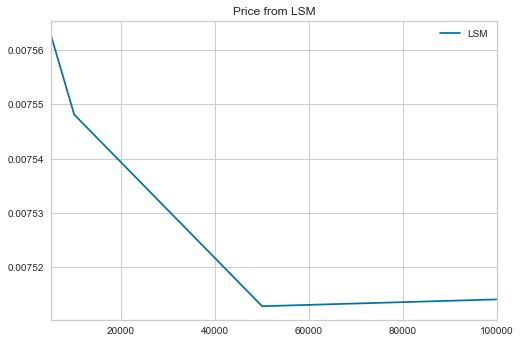

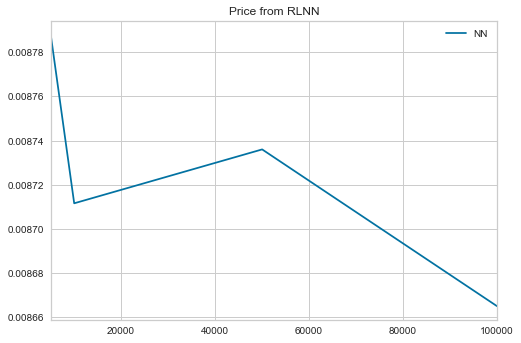

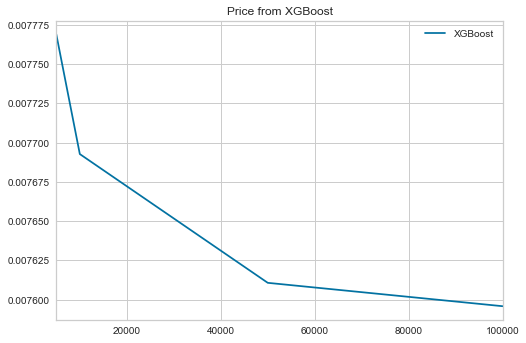

In [289]:
import matplotlib.pyplot as plt

output_table.plot(kind='line',y='LSM',title='Price from LSM')
plt.show()
output_table.plot(kind='line',y='NN',title='Price from RLNN')
plt.show()
output_table.plot(kind='line',y='XGBoost',title='Price from XGBoost')
plt.show()

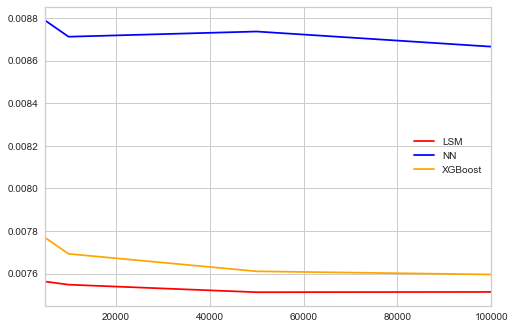

In [290]:
ax=plt.gca()
output_table.plot(kind='line',y='LSM',color='red',ax=ax)
output_table.plot(kind='line',y='NN',color='blue',ax=ax)
output_table.plot(kind='line',y='XGBoost',color='orange',ax=ax)

#### NN will always generate bigger values than LSM and XGBoost do, also it converges faster than XGBoost, in order to see the number of paths that XGBoost nees to converge, we built another 500,000 paths  sim_rates and plot the results.

In [134]:
sim_rates_500k=smm(DFT, corr, 500000, len(para),para)

In [147]:
%%time
prc_lsm_500k=Bermudan_swaption_lsm(lockout,maturity,sim_rates_500k,strike,alpha)

Wall time: 33 s


In [149]:
%%time
prc_nn_500k=Bermudan_swaption_nn(lockout,maturity,sim_rates_500k,strike,n_epochs,batch_size,learningrate)

At step 18
Epoch 1/10, train_loss: 0.01395, valid_loss: 0.00075
Epoch 2/10, train_loss: 0.00988, valid_loss: 0.00075
Epoch 3/10, train_loss: 0.00807, valid_loss: 0.00075
Epoch 4/10, train_loss: 0.00700, valid_loss: 0.00075
Epoch 5/10, train_loss: 0.00627, valid_loss: 0.00075
Epoch 6/10, train_loss: 0.00573, valid_loss: 0.00075
Epoch 7/10, train_loss: 0.00532, valid_loss: 0.00075
Epoch 8/10, train_loss: 0.00498, valid_loss: 0.00074
Epoch 9/10, train_loss: 0.00470, valid_loss: 0.00074
Epoch 10/10, train_loss: 0.00447, valid_loss: 0.00074
At step 17
Epoch 1/10, train_loss: 0.01694, valid_loss: 0.00143
Epoch 2/10, train_loss: 0.01202, valid_loss: 0.00143
Epoch 3/10, train_loss: 0.00985, valid_loss: 0.00143
Epoch 4/10, train_loss: 0.00856, valid_loss: 0.00143
Epoch 5/10, train_loss: 0.00768, valid_loss: 0.00143
Epoch 6/10, train_loss: 0.00704, valid_loss: 0.00143
Epoch 7/10, train_loss: 0.00654, valid_loss: 0.00142
Epoch 8/10, train_loss: 0.00613, valid_loss: 0.00142
Epoch 9/10, train_loss:

Epoch 3/10, train_loss: 0.00776, valid_loss: 0.00614
Epoch 4/10, train_loss: 0.00716, valid_loss: 0.00590
Epoch 5/10, train_loss: 0.00678, valid_loss: 0.00571
Epoch 6/10, train_loss: 0.00651, valid_loss: 0.00557
Epoch 7/10, train_loss: 0.00631, valid_loss: 0.00546
Epoch 8/10, train_loss: 0.00615, valid_loss: 0.00538
Epoch 9/10, train_loss: 0.00602, valid_loss: 0.00533
Epoch 10/10, train_loss: 0.00591, valid_loss: 0.00533
At step 2
Epoch 1/10, train_loss: 0.01197, valid_loss: 0.00689
Epoch 2/10, train_loss: 0.00966, valid_loss: 0.00651
Epoch 3/10, train_loss: 0.00855, valid_loss: 0.00612
Epoch 4/10, train_loss: 0.00787, valid_loss: 0.00593
Epoch 5/10, train_loss: 0.00743, valid_loss: 0.00580
Epoch 6/10, train_loss: 0.00712, valid_loss: 0.00570
Epoch 7/10, train_loss: 0.00688, valid_loss: 0.00562
Epoch 8/10, train_loss: 0.00669, valid_loss: 0.00555
Epoch 9/10, train_loss: 0.00654, valid_loss: 0.00554
Epoch 10/10, train_loss: 0.00642, valid_loss: 0.00550
Wall time: 10min 10s


In [241]:
%%time
prc_xgb_500k=Bermudan_swaption_xgboost_fixed(lockout,maturity,sim_rates_500k,strike,seed)

Wall time: 3min 25s


In [242]:
print_result(prc_xgb_500k)

European swaption pirce: 0.006943124318928889
Bermudan swaption pirce: 0.0076011020883241225
Excercise Probability Table
    Time_step  ex_prob_Euro  ex_prob_xgb
0           2      0.707186     0.599610
1           3      0.000000     0.059324
2           4      0.000000     0.025002
3           5      0.000000     0.013884
4           6      0.000000     0.008570
5           7      0.000000     0.005944
6           8      0.000000     0.004304
7           9      0.000000     0.003380
8          10      0.000000     0.002512
9          11      0.000000     0.002576
10         12      0.000000     0.002574
11         13      0.000000     0.002982
12         14      0.000000     0.003232
13         15      0.000000     0.003594
14         16      0.000000     0.003952
15         17      0.000000     0.005030
16         18      0.000000     0.006316
17         19      0.000000     0.008356


In [243]:
df2=make_table(prc_lsm_500k,prc_nn_500k,prc_xgb_500k)

In [244]:
df2=pd.DataFrame(np.concatenate([output_table.to_numpy(), df2.iloc[:,2].to_numpy().reshape((1,-1))]))

In [245]:
df2.columns=['LSM','Regress now','XGBoost']
df2.index=['5000','10000','50000','100000','500000']


In [246]:
df2

,LSM,Regress now,XGBoost
5000,0.007563,0.008798,0.007769
10000,0.007548,0.008774,0.007693
50000,0.007513,0.008731,0.007611
100000,0.007514,0.008706,0.007596
500000,0.007515,0.008667,0.007601


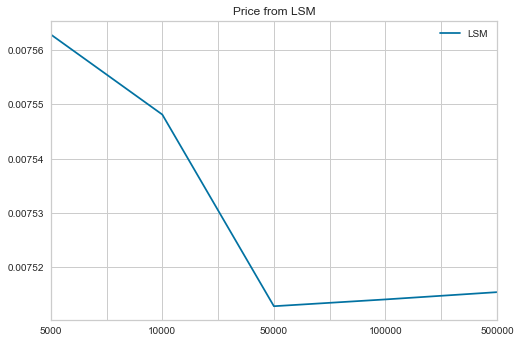

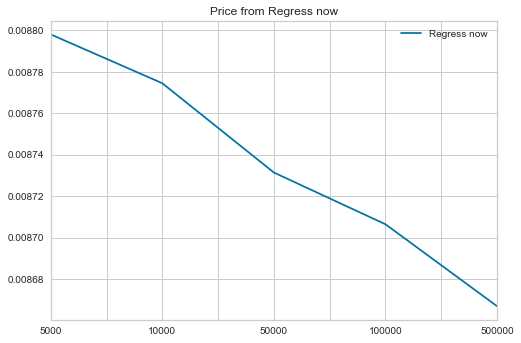

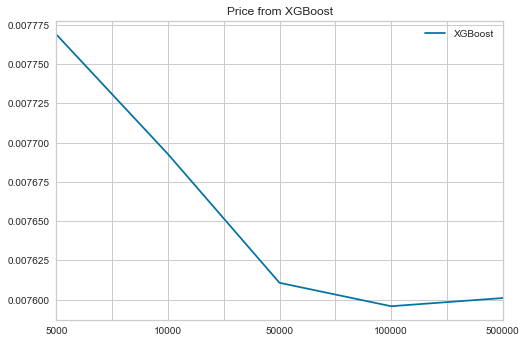

In [247]:
df2.plot(kind='line',y='LSM',title='Price from LSM')
plt.show()
df2.plot(kind='line',y='Regress now',title='Price from Regress now')
plt.show()
df2.plot(kind='line',y='XGBoost',title='Price from XGBoost')
plt.show()

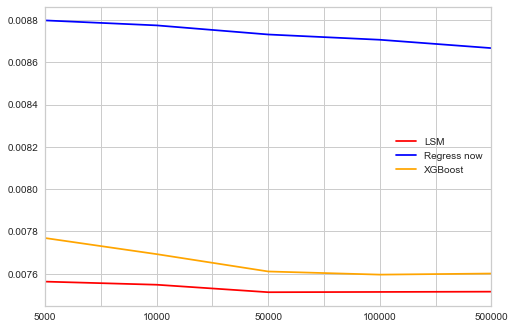

In [248]:
ax=plt.gca()
df2.plot(kind='line',y='LSM',color='red',ax=ax)
df2.plot(kind='line',y='Regress now',color='blue',ax=ax)
df2.plot(kind='line',y='XGBoost',color='orange',ax=ax)

####  XGBoost model seems to converge after 100,000 paths, though it's still decreasing.

In [ ]:
df2.to_csv('output_008_1105.csv',index=False)

In [140]:
sim_rates_1m=smm(DFT, corr, 1000000, len(para),para)
prc_xgb_1m=Bermudan_swaption_xgboost_fixed(lockout,maturity,sim_rates_1m,strike,seed)
path_series=np.append(path_series,1000000)

In [202]:
xgb_series=np.append(df2['XGBoost'].values,prc_xgb_1m[1])

In [203]:
path_series

array([   5000,   10000,   50000,  100000,  500000, 1000000], dtype=int64)

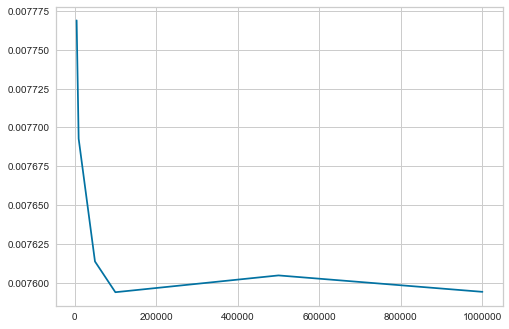

In [204]:
plt.plot(path_series,xgb_series)

#### Even we simulated 1 million paths this time, the results did not increase

### Now let's move to the Regress later approach

#### for a 1 into 9 swaptions,1 year later, it's expected continuation value can be seen the 0.5 into 8.5 swaption, so I calculate the expected value at each time step, then do the regress later using NN

In [291]:
def Bermudan_swaption_rlnn(lockout,maturity,sim_rates,strike,n_epochs,batch_size,learningrate):
    expiry=int(2*lockout)
    tenor=int(2*maturity)
    
    step=tenor-expiry  # 18
    paths=sim_rates.shape[2] # 5000
    di = np.diag_indices(expiry) # 1y 2 dis
    
# discount factor for calculate the final prc
    cmmf = np.prod(sim_rates[di], axis = 0) # (5000,1)
    
    rates=sim_rates[expiry:tenor,expiry:tenor,:] #18*18*5000
    
    di=np.diag_indices(int(tenor-expiry-1))
    di=(di[0]+expiry,di[1]+expiry)
    
# discount map for each related time step 
    discount_mat=np.hstack((np.ones((paths,1)),np.cumprod(sim_rates[di],axis=0).T)) #5000 * 18

# initial matrix

    value_rlnn,index_rlnn=np.zeros((paths,step)),np.zeros((paths,step))
    
# calculate the par rate at 18 possible excercise date
    denominator=np.sum(sim_rates[expiry-1:tenor,expiry:tenor,:],axis=0)-1 # 18*5000 3D to 2D
    
    numerator=2*(1-sim_rates[int(tenor-1),expiry:tenor,:]) # 18*5000
    par=numerator/denominator # 18*5000
    payoff_mat = 0.5 * np.maximum(strike-par.T, 0) * denominator.T #5000 *100
    
# calculate the forward par rates
    di_half = np.diag_indices(tenor-expiry) # 18
    half_year_disc=rates[di_half] # 18*5000
    denominator_forward_par=denominator-half_year_disc # last step will be 0
    numerator_forward_par=2*(half_year_disc-sim_rates[int(tenor-1),expiry:tenor,:])
    forward_par=numerator_forward_par/ denominator_forward_par
    payoff_fp_mat= 0.5 * np.maximum(strike-forward_par.T, 0) * denominator_forward_par.T  #5000*18
    
    index_rlnn[:,-1]=np.where(payoff_mat[:,-1]>0,1,0)
    value_rlnn[:,-1]=payoff_mat[:,-1]
    
# European swaption price and ex prob
    Euro_prc=np.mean(payoff_mat[:,0]*cmmf)
    ex_prob=np.sum(np.where(payoff_mat[:,0]>0,1,0))/paths    
            
    for i in range(step-2,-1,-1):
        cv=payoff_fp_mat[:,i].reshape((paths,1)) # 5000*1
        ev=payoff_mat[:,i].reshape((paths,1)) # 5000*1
        bond_prc=rates[i:int(tenor-expiry),i,:].T # 5000*n
        
# construct the basis functions        
#        swap_value = np.repeat(ev, 3, axis = 1) ** np.arange(1, 4) # 5000*3
        swap_value = Laguerre_feature(ev.ravel(),3)
        constant=np.ones((paths,1))
#        basis=np.hstack((np.hstack((constant,bond_prc)),swap_value))
        bond_prc_laguerre=np.apply_along_axis(Laguerre_feature,0,bond_prc,k=3).reshape((paths,-1))
        basis=np.hstack((np.hstack((constant,bond_prc_laguerre)),swap_value))
        

        # Regress later NN
        mask=ev.ravel()>0
        ev=ev[mask]
        cv=cv[mask] #(1327, 1)
        basis=basis[mask] # (1327, 10)
        
        
        print('At step {}'.format(i+2))
        cv_rlnn=trainNN(basis,cv,n_epochs,batch_size,learningrate)
        value_rlnn[mask,i]=np.where(ev>cv_rlnn,ev,cv).ravel() # cv instead of cv_rlnn
        index_rlnn[mask,i]=np.where(ev>cv,1,0).ravel()
        
        for j in range(i+1,index_rlnn.shape[1]):            
             index_rlnn[:,j][index_rlnn[:,int(i)]==1]=0
             
    prob=pd.DataFrame({'Time_step': np.arange(expiry,tenor),
                       'ex_prob_Euro':np.append(ex_prob,np.repeat(0,step-1)),
                       'ex_prob_RLNN':np.sum(index_rlnn,axis=0)/paths})

    price_rlnn=np.mean(np.sum(np.multiply(discount_mat,np.multiply(index_rlnn,payoff_mat)),axis=1)*cmmf)
    
    return Euro_prc,price_rlnn,prob

In [292]:
# 5000 paths

prc_rlnn=Bermudan_swaption_rlnn(lockout,maturity,sim_rates,strike,n_epochs,batch_size,learningrate)
# 10k paths
prc_rlnn_10k=Bermudan_swaption_rlnn(lockout,maturity,sim_rates_10k,strike,n_epochs,batch_size,learningrate)
# 50k paths
prc_rlnn_50k=Bermudan_swaption_rlnn(lockout,maturity,sim_rates_50k,strike,n_epochs,batch_size,learningrate)
# 100k paths
prc_rlnn_100k=Bermudan_swaption_rlnn(lockout,maturity,sim_rates_100k,strike,n_epochs,batch_size,learningrate)

At step 18
Epoch 1/30, train_loss: 0.02517, valid_loss: 0.00728
Epoch 2/30, train_loss: 0.01890, valid_loss: 0.00520
Epoch 3/30, train_loss: 0.01558, valid_loss: 0.00435
Epoch 4/30, train_loss: 0.01352, valid_loss: 0.00385
Epoch 5/30, train_loss: 0.01210, valid_loss: 0.00346
Epoch 6/30, train_loss: 0.01105, valid_loss: 0.00317
Epoch 7/30, train_loss: 0.01023, valid_loss: 0.00295
Epoch 8/30, train_loss: 0.00957, valid_loss: 0.00277
Epoch 9/30, train_loss: 0.00903, valid_loss: 0.00262
Epoch 10/30, train_loss: 0.00857, valid_loss: 0.00249
Epoch 11/30, train_loss: 0.00817, valid_loss: 0.00238
Epoch 12/30, train_loss: 0.00783, valid_loss: 0.00229
Epoch 13/30, train_loss: 0.00752, valid_loss: 0.00221
Epoch 14/30, train_loss: 0.00725, valid_loss: 0.00214
Epoch 15/30, train_loss: 0.00701, valid_loss: 0.00207
Epoch 16/30, train_loss: 0.00679, valid_loss: 0.00201
Epoch 17/30, train_loss: 0.00658, valid_loss: 0.00196
Epoch 18/30, train_loss: 0.00640, valid_loss: 0.00191
Epoch 19/30, train_loss: 0

Epoch 8/30, train_loss: 0.01338, valid_loss: 0.00932
Epoch 9/30, train_loss: 0.01268, valid_loss: 0.00886
Epoch 10/30, train_loss: 0.01209, valid_loss: 0.00848
Epoch 11/30, train_loss: 0.01158, valid_loss: 0.00816
Epoch 12/30, train_loss: 0.01114, valid_loss: 0.00787
Epoch 13/30, train_loss: 0.01076, valid_loss: 0.00762
Epoch 14/30, train_loss: 0.01041, valid_loss: 0.00741
Epoch 15/30, train_loss: 0.01011, valid_loss: 0.00721
Epoch 16/30, train_loss: 0.00983, valid_loss: 0.00705
Epoch 17/30, train_loss: 0.00958, valid_loss: 0.00691
Epoch 18/30, train_loss: 0.00936, valid_loss: 0.00677
Epoch 19/30, train_loss: 0.00915, valid_loss: 0.00663
Epoch 20/30, train_loss: 0.00896, valid_loss: 0.00651
Epoch 21/30, train_loss: 0.00878, valid_loss: 0.00640
Epoch 22/30, train_loss: 0.00862, valid_loss: 0.00630
Epoch 23/30, train_loss: 0.00847, valid_loss: 0.00620
Epoch 24/30, train_loss: 0.00833, valid_loss: 0.00610
Epoch 25/30, train_loss: 0.00819, valid_loss: 0.00603
Epoch 26/30, train_loss: 0.008

Epoch 10/30, train_loss: 0.00878, valid_loss: 0.00672
Epoch 11/30, train_loss: 0.00852, valid_loss: 0.00655
Epoch 12/30, train_loss: 0.00830, valid_loss: 0.00641
Epoch 13/30, train_loss: 0.00811, valid_loss: 0.00630
Epoch 14/30, train_loss: 0.00794, valid_loss: 0.00620
Epoch 15/30, train_loss: 0.00780, valid_loss: 0.00616
Epoch 16/30, train_loss: 0.00768, valid_loss: 0.00609
Epoch 17/30, train_loss: 0.00755, valid_loss: 0.00601
Epoch 18/30, train_loss: 0.00744, valid_loss: 0.00591
Epoch 19/30, train_loss: 0.00733, valid_loss: 0.00583
Epoch 20/30, train_loss: 0.00722, valid_loss: 0.00576
Epoch 21/30, train_loss: 0.00712, valid_loss: 0.00568
Epoch 22/30, train_loss: 0.00702, valid_loss: 0.00563
Epoch 23/30, train_loss: 0.00693, valid_loss: 0.00556
Epoch 24/30, train_loss: 0.00685, valid_loss: 0.00549
Epoch 25/30, train_loss: 0.00677, valid_loss: 0.00543
Epoch 26/30, train_loss: 0.00668, valid_loss: 0.00538
Epoch 27/30, train_loss: 0.00661, valid_loss: 0.00532
Epoch 28/30, train_loss: 0.0

Epoch 13/30, train_loss: 0.00675, valid_loss: 0.00618
Epoch 14/30, train_loss: 0.00665, valid_loss: 0.00609
Epoch 15/30, train_loss: 0.00652, valid_loss: 0.00605
Epoch 16/30, train_loss: 0.00642, valid_loss: 0.00600
Epoch 17/30, train_loss: 0.00634, valid_loss: 0.00593
Epoch 18/30, train_loss: 0.00624, valid_loss: 0.00583
Epoch 19/30, train_loss: 0.00614, valid_loss: 0.00576
Epoch 20/30, train_loss: 0.00604, valid_loss: 0.00566
Epoch 21/30, train_loss: 0.00593, valid_loss: 0.00561
Epoch 22/30, train_loss: 0.00584, valid_loss: 0.00554
Epoch 23/30, train_loss: 0.00574, valid_loss: 0.00544
Epoch 24/30, train_loss: 0.00564, valid_loss: 0.00534
Epoch 25/30, train_loss: 0.00555, valid_loss: 0.00526
Epoch 26/30, train_loss: 0.00546, valid_loss: 0.00517
Epoch 27/30, train_loss: 0.00538, valid_loss: 0.00509
Epoch 28/30, train_loss: 0.00530, valid_loss: 0.00502
Epoch 29/30, train_loss: 0.00522, valid_loss: 0.00495
Epoch 30/30, train_loss: 0.00515, valid_loss: 0.00488
At step 2
Epoch 1/30, train_

Epoch 17/30, train_loss: 0.01378, valid_loss: 0.00554
Epoch 18/30, train_loss: 0.01340, valid_loss: 0.00541
Epoch 19/30, train_loss: 0.01306, valid_loss: 0.00530
Epoch 20/30, train_loss: 0.01274, valid_loss: 0.00519
Epoch 21/30, train_loss: 0.01244, valid_loss: 0.00509
Epoch 22/30, train_loss: 0.01217, valid_loss: 0.00501
Epoch 23/30, train_loss: 0.01191, valid_loss: 0.00492
Epoch 24/30, train_loss: 0.01167, valid_loss: 0.00485
Epoch 25/30, train_loss: 0.01144, valid_loss: 0.00477
Epoch 26/30, train_loss: 0.01123, valid_loss: 0.00471
Epoch 27/30, train_loss: 0.01103, valid_loss: 0.00465
Epoch 28/30, train_loss: 0.01084, valid_loss: 0.00459
Epoch 29/30, train_loss: 0.01066, valid_loss: 0.00453
Epoch 30/30, train_loss: 0.01049, valid_loss: 0.00448
At step 14
Epoch 1/30, train_loss: 0.02370, valid_loss: 0.00297
Epoch 2/30, train_loss: 0.01713, valid_loss: 0.00314
Epoch 3/30, train_loss: 0.01409, valid_loss: 0.00302
Epoch 4/30, train_loss: 0.01228, valid_loss: 0.00303
Epoch 5/30, train_los

Epoch 21/30, train_loss: 0.00469, valid_loss: 0.00430
Epoch 22/30, train_loss: 0.00459, valid_loss: 0.00422
Epoch 23/30, train_loss: 0.00451, valid_loss: 0.00414
Epoch 24/30, train_loss: 0.00442, valid_loss: 0.00408
Epoch 25/30, train_loss: 0.00434, valid_loss: 0.00400
Epoch 26/30, train_loss: 0.00426, valid_loss: 0.00393
Epoch 27/30, train_loss: 0.00419, valid_loss: 0.00386
Epoch 28/30, train_loss: 0.00413, valid_loss: 0.00380
Epoch 29/30, train_loss: 0.00406, valid_loss: 0.00374
Epoch 30/30, train_loss: 0.00400, valid_loss: 0.00368
At step 9
Epoch 1/30, train_loss: 0.03807, valid_loss: 0.00543
Epoch 2/30, train_loss: 0.02729, valid_loss: 0.00517
Epoch 3/30, train_loss: 0.02251, valid_loss: 0.00514
Epoch 4/30, train_loss: 0.01969, valid_loss: 0.00512
Epoch 5/30, train_loss: 0.01778, valid_loss: 0.00510
Epoch 6/30, train_loss: 0.01638, valid_loss: 0.00512
Epoch 7/30, train_loss: 0.01531, valid_loss: 0.00511
Epoch 8/30, train_loss: 0.01445, valid_loss: 0.00508
Epoch 9/30, train_loss: 0.

Epoch 24/30, train_loss: 0.00452, valid_loss: 0.00400
Epoch 25/30, train_loss: 0.00443, valid_loss: 0.00395
Epoch 26/30, train_loss: 0.00436, valid_loss: 0.00388
Epoch 27/30, train_loss: 0.00429, valid_loss: 0.00382
Epoch 28/30, train_loss: 0.00422, valid_loss: 0.00377
Epoch 29/30, train_loss: 0.00416, valid_loss: 0.00371
Epoch 30/30, train_loss: 0.00410, valid_loss: 0.00365
At step 4
Epoch 1/30, train_loss: 0.01156, valid_loss: 0.00645
Epoch 2/30, train_loss: 0.00945, valid_loss: 0.00634
Epoch 3/30, train_loss: 0.00858, valid_loss: 0.00621
Epoch 4/30, train_loss: 0.00811, valid_loss: 0.00613
Epoch 5/30, train_loss: 0.00774, valid_loss: 0.00597
Epoch 6/30, train_loss: 0.00742, valid_loss: 0.00580
Epoch 7/30, train_loss: 0.00713, valid_loss: 0.00568
Epoch 8/30, train_loss: 0.00690, valid_loss: 0.00547
Epoch 9/30, train_loss: 0.00664, valid_loss: 0.00529
Epoch 10/30, train_loss: 0.00640, valid_loss: 0.00518
Epoch 11/30, train_loss: 0.00616, valid_loss: 0.00500
Epoch 12/30, train_loss: 0.

Epoch 26/30, train_loss: 0.00172, valid_loss: 0.00203
Epoch 27/30, train_loss: 0.00170, valid_loss: 0.00200
Epoch 28/30, train_loss: 0.00168, valid_loss: 0.00198
Epoch 29/30, train_loss: 0.00165, valid_loss: 0.00195
Epoch 30/30, train_loss: 0.00163, valid_loss: 0.00191
At step 16
Epoch 1/30, train_loss: 0.02588, valid_loss: 0.00206
Epoch 2/30, train_loss: 0.01836, valid_loss: 0.00206
Epoch 3/30, train_loss: 0.01504, valid_loss: 0.00207
Epoch 4/30, train_loss: 0.01306, valid_loss: 0.00207
Epoch 5/30, train_loss: 0.01172, valid_loss: 0.00206
Epoch 6/30, train_loss: 0.01073, valid_loss: 0.00205
Epoch 7/30, train_loss: 0.00997, valid_loss: 0.00208
Epoch 8/30, train_loss: 0.00935, valid_loss: 0.00213
Epoch 9/30, train_loss: 0.00884, valid_loss: 0.00211
Epoch 10/30, train_loss: 0.00841, valid_loss: 0.00209
Epoch 11/30, train_loss: 0.00804, valid_loss: 0.00208
Epoch 12/30, train_loss: 0.00772, valid_loss: 0.00206
Epoch 13/30, train_loss: 0.00744, valid_loss: 0.00208
Epoch 14/30, train_loss: 0

Epoch 28/30, train_loss: 0.00360, valid_loss: 0.00236
Epoch 29/30, train_loss: 0.00354, valid_loss: 0.00232
Epoch 30/30, train_loss: 0.00349, valid_loss: 0.00230
At step 11
Epoch 1/30, train_loss: 0.01311, valid_loss: 0.00452
Epoch 2/30, train_loss: 0.00977, valid_loss: 0.00449
Epoch 3/30, train_loss: 0.00835, valid_loss: 0.00449
Epoch 4/30, train_loss: 0.00752, valid_loss: 0.00440
Epoch 5/30, train_loss: 0.00696, valid_loss: 0.00433
Epoch 6/30, train_loss: 0.00655, valid_loss: 0.00422
Epoch 7/30, train_loss: 0.00621, valid_loss: 0.00415
Epoch 8/30, train_loss: 0.00592, valid_loss: 0.00413
Epoch 9/30, train_loss: 0.00566, valid_loss: 0.00399
Epoch 10/30, train_loss: 0.00542, valid_loss: 0.00384
Epoch 11/30, train_loss: 0.00520, valid_loss: 0.00370
Epoch 12/30, train_loss: 0.00499, valid_loss: 0.00360
Epoch 13/30, train_loss: 0.00481, valid_loss: 0.00348
Epoch 14/30, train_loss: 0.00465, valid_loss: 0.00338
Epoch 15/30, train_loss: 0.00450, valid_loss: 0.00327
Epoch 16/30, train_loss: 0

Epoch 30/30, train_loss: 0.00301, valid_loss: 0.00221
At step 6
Epoch 1/30, train_loss: 0.01401, valid_loss: 0.00615
Epoch 2/30, train_loss: 0.01081, valid_loss: 0.00601
Epoch 3/30, train_loss: 0.00942, valid_loss: 0.00577
Epoch 4/30, train_loss: 0.00854, valid_loss: 0.00545
Epoch 5/30, train_loss: 0.00785, valid_loss: 0.00509
Epoch 6/30, train_loss: 0.00726, valid_loss: 0.00474
Epoch 7/30, train_loss: 0.00677, valid_loss: 0.00443
Epoch 8/30, train_loss: 0.00636, valid_loss: 0.00417
Epoch 9/30, train_loss: 0.00602, valid_loss: 0.00395
Epoch 10/30, train_loss: 0.00574, valid_loss: 0.00377
Epoch 11/30, train_loss: 0.00549, valid_loss: 0.00366
Epoch 12/30, train_loss: 0.00528, valid_loss: 0.00353
Epoch 13/30, train_loss: 0.00509, valid_loss: 0.00341
Epoch 14/30, train_loss: 0.00492, valid_loss: 0.00330
Epoch 15/30, train_loss: 0.00477, valid_loss: 0.00320
Epoch 16/30, train_loss: 0.00463, valid_loss: 0.00311
Epoch 17/30, train_loss: 0.00450, valid_loss: 0.00302
Epoch 18/30, train_loss: 0.

Epoch 2/30, train_loss: 0.00481, valid_loss: 0.00069
Epoch 3/30, train_loss: 0.00395, valid_loss: 0.00069
Epoch 4/30, train_loss: 0.00344, valid_loss: 0.00068
Epoch 5/30, train_loss: 0.00309, valid_loss: 0.00070
Epoch 6/30, train_loss: 0.00284, valid_loss: 0.00072
Epoch 7/30, train_loss: 0.00268, valid_loss: 0.00070
Epoch 8/30, train_loss: 0.00252, valid_loss: 0.00076
Epoch 9/30, train_loss: 0.00239, valid_loss: 0.00083
Epoch 10/30, train_loss: 0.00228, valid_loss: 0.00081
Epoch 11/30, train_loss: 0.00219, valid_loss: 0.00081
Epoch 12/30, train_loss: 0.00211, valid_loss: 0.00079
Epoch 13/30, train_loss: 0.00205, valid_loss: 0.00087
Epoch 14/30, train_loss: 0.00199, valid_loss: 0.00085
Epoch 15/30, train_loss: 0.00193, valid_loss: 0.00087
Epoch 16/30, train_loss: 0.00194, valid_loss: 0.00085
Epoch 17/30, train_loss: 0.00189, valid_loss: 0.00083
Epoch 18/30, train_loss: 0.00184, valid_loss: 0.00082
Epoch 19/30, train_loss: 0.00179, valid_loss: 0.00081
Epoch 20/30, train_loss: 0.00175, va

Epoch 4/30, train_loss: 0.00328, valid_loss: 0.00274
Epoch 5/30, train_loss: 0.00300, valid_loss: 0.00255
Epoch 6/30, train_loss: 0.00279, valid_loss: 0.00235
Epoch 7/30, train_loss: 0.00262, valid_loss: 0.00219
Epoch 8/30, train_loss: 0.00249, valid_loss: 0.00210
Epoch 9/30, train_loss: 0.00238, valid_loss: 0.00199
Epoch 10/30, train_loss: 0.00228, valid_loss: 0.00190
Epoch 11/30, train_loss: 0.00220, valid_loss: 0.00184
Epoch 12/30, train_loss: 0.00213, valid_loss: 0.00178
Epoch 13/30, train_loss: 0.00206, valid_loss: 0.00175
Epoch 14/30, train_loss: 0.00201, valid_loss: 0.00169
Epoch 15/30, train_loss: 0.00196, valid_loss: 0.00164
Epoch 16/30, train_loss: 0.00191, valid_loss: 0.00159
Epoch 17/30, train_loss: 0.00186, valid_loss: 0.00155
Epoch 18/30, train_loss: 0.00183, valid_loss: 0.00154
Epoch 19/30, train_loss: 0.00179, valid_loss: 0.00151
Epoch 20/30, train_loss: 0.00175, valid_loss: 0.00148
Epoch 21/30, train_loss: 0.00172, valid_loss: 0.00145
Epoch 22/30, train_loss: 0.00169, 

Epoch 6/30, train_loss: 0.00572, valid_loss: 0.00325
Epoch 7/30, train_loss: 0.00532, valid_loss: 0.00308
Epoch 8/30, train_loss: 0.00499, valid_loss: 0.00290
Epoch 9/30, train_loss: 0.00473, valid_loss: 0.00276
Epoch 10/30, train_loss: 0.00451, valid_loss: 0.00263
Epoch 11/30, train_loss: 0.00431, valid_loss: 0.00254
Epoch 12/30, train_loss: 0.00414, valid_loss: 0.00244
Epoch 13/30, train_loss: 0.00399, valid_loss: 0.00235
Epoch 14/30, train_loss: 0.00386, valid_loss: 0.00227
Epoch 15/30, train_loss: 0.00374, valid_loss: 0.00221
Epoch 16/30, train_loss: 0.00363, valid_loss: 0.00217
Epoch 17/30, train_loss: 0.00353, valid_loss: 0.00214
Epoch 18/30, train_loss: 0.00344, valid_loss: 0.00209
Epoch 19/30, train_loss: 0.00335, valid_loss: 0.00204
Epoch 20/30, train_loss: 0.00327, valid_loss: 0.00199
Epoch 21/30, train_loss: 0.00320, valid_loss: 0.00198
Epoch 22/30, train_loss: 0.00313, valid_loss: 0.00193
Epoch 23/30, train_loss: 0.00307, valid_loss: 0.00189
Epoch 24/30, train_loss: 0.00301

Epoch 8/30, train_loss: 0.00302, valid_loss: 0.00226
Epoch 9/30, train_loss: 0.00286, valid_loss: 0.00215
Epoch 10/30, train_loss: 0.00273, valid_loss: 0.00205
Epoch 11/30, train_loss: 0.00263, valid_loss: 0.00196
Epoch 12/30, train_loss: 0.00252, valid_loss: 0.00195
Epoch 13/30, train_loss: 0.00243, valid_loss: 0.00187
Epoch 14/30, train_loss: 0.00235, valid_loss: 0.00181
Epoch 15/30, train_loss: 0.00228, valid_loss: 0.00177
Epoch 16/30, train_loss: 0.00221, valid_loss: 0.00173
Epoch 17/30, train_loss: 0.00215, valid_loss: 0.00169
Epoch 18/30, train_loss: 0.00210, valid_loss: 0.00165
Epoch 19/30, train_loss: 0.00205, valid_loss: 0.00160
Epoch 20/30, train_loss: 0.00200, valid_loss: 0.00157
Epoch 21/30, train_loss: 0.00196, valid_loss: 0.00153
Epoch 22/30, train_loss: 0.00192, valid_loss: 0.00150
Epoch 23/30, train_loss: 0.00188, valid_loss: 0.00147
Epoch 24/30, train_loss: 0.00184, valid_loss: 0.00144
Epoch 25/30, train_loss: 0.00181, valid_loss: 0.00142
Epoch 26/30, train_loss: 0.001

In [294]:
path_series=np.array([5000,10000,50000,100000])
rlnn_series=np.array([prc_rlnn[1],prc_rlnn_10k[1],prc_rlnn_50k[1],prc_rlnn_100k[1]])

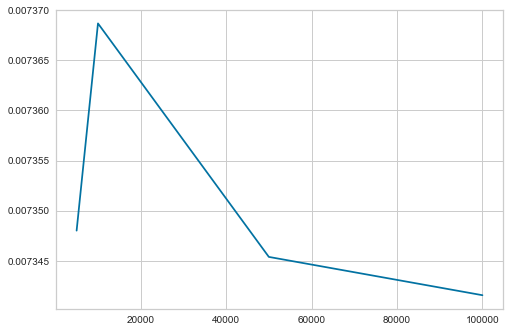

In [295]:
plt.plot(path_series,rlnn_series)

#### Now the prc from RLNN is significantly lower than regress now approach

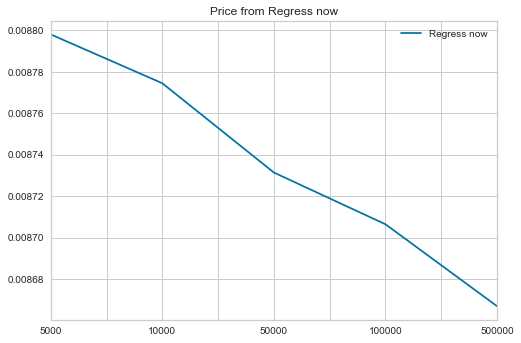

In [296]:
df2.plot(kind='line',y='Regress now',title='Price from Regress now')
plt.show()

In [ ]:
def train_xgb(basis,cv,seed):
    train_x=basis
    train_y=cv
# base model
    model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=seed)
# para range for search the optimal para
    parameters_for_testing = {
    'colsample_bytree':[0.4,0.6,0.8],
    'gamma':[0,0.03,0.1,0.3],
    'min_child_weight':[1.5,6,10],
    'learning_rate':[0.001,0.005,0.01],
    'max_depth':[3,5],
    'n_estimators':[5,10],
    'reg_alpha':[1e-5, 1e-2,  0.75],
    'reg_lambda':[1e-5, 1e-2, 0.45],
    'subsample':[0.6,0.95]}
# searching     
    gsearch1 = GridSearchCV(estimator = model, param_grid = parameters_for_testing, n_jobs=6,iid=False, verbose=10,scoring='neg_mean_squared_error')
    gsearch1.fit(train_x,train_y)
# get the best para
    para=gsearch1.best_params_
    
    best_xgb_model=xgboost.XGBRegressor(colsample_bytree=para['colsample_bytree'],
                 gamma=para['gamma'],                 
                 learning_rate=para['learning_rate'],
                 max_depth=para['max_depth'],
                 min_child_weight=para['min_child_weight'],
                 n_estimators=para['n_estimators'],                                                                    
                 reg_alpha=para['reg_alpha'],
                 reg_lambda=para['reg_lambda'],
                 subsample=para[ 'subsample'],
                 seed=seed)
# fit the model
    best_xgb_model.fit(train_x,train_y)
    y_xgb=best_xgb_model.predict(train_x).reshape((-1,1))
    return y_xgb